In [1]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
import corner
import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle

In [227]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler
import multiprocessing

# Get Data Spectra

3723


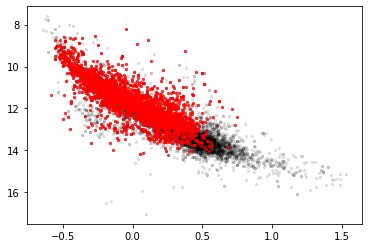

In [207]:
wdtable = Table.read('wdtable_sn.fits')

good = (
    (wdtable['subclass'] == 'WD')[:,0].data
)

print(len(wdtable[good]))
plt.scatter(wdtable['bp_rp'],wdtable['abs_g'],s = 5, alpha=0.1,color='k')
plt.scatter(wdtable[good]['bp_rp'],wdtable[good]['abs_g'],s = 5, alpha=0.7,color='r')
plt.gca().invert_yaxis()
wdtable = wdtable[good]

In [208]:
bgrid = np.linspace(np.min(wdtable['bp_rp']),np.max(wdtable['bp_rp']),25)
ggrid = np.linspace(np.min(wdtable['abs_g']),np.max(wdtable['abs_g']),25)
bint = bgrid[1]-bgrid[0]
gint = ggrid[1]-ggrid[0]

In [209]:
wdtable['selected'] = np.zeros(len(wdtable))

In [210]:
selections = [];
for i in tqdm(bgrid):
    for j in ggrid:
        square = (wdtable['bp_rp'] > i)*(wdtable['abs_g'] > j)*\
                (wdtable['bp_rp'] < i+bint)*(wdtable['abs_g'] < j+gint)
        if len(wdtable[square]) > 0:
            snmaxidx = np.argmax(wdtable[square]['S2N'])
            selections.append(wdtable[square][snmaxidx]['specnames'])


100%|██████████| 25/25 [00:22<00:00,  1.64it/s]

In [211]:
idxs = [];
for i in selections:
    idxs.append(np.argmax(wdtable['specnames'] == i))

In [212]:
goodtable = wdtable[idxs]

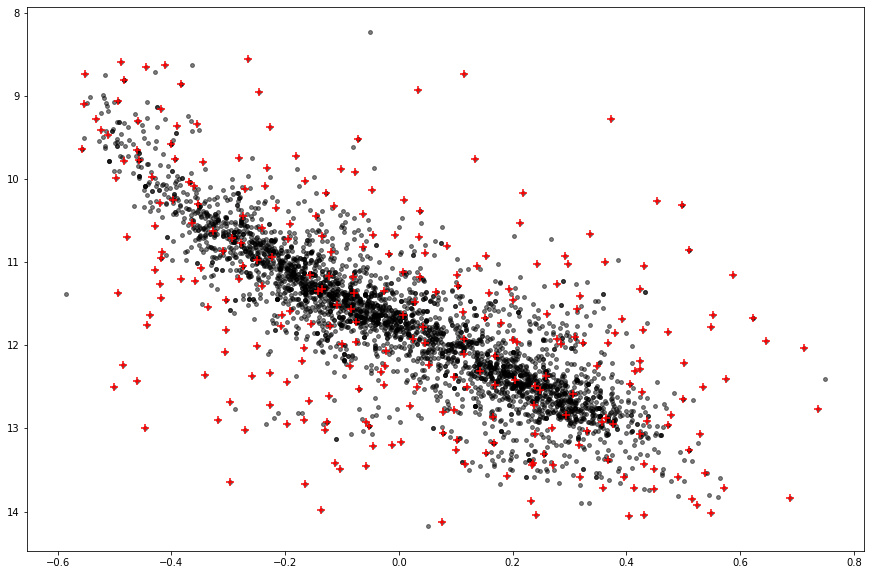

In [213]:
plt.figure(figsize=(15,10))
plt.scatter(wdtable['bp_rp'],wdtable['abs_g'],s=15,color='k',alpha=0.5)
plt.scatter(goodtable['bp_rp'],goodtable['abs_g'],s=55,color='r',marker='+')
plt.gca().invert_yaxis()

In [214]:
bigtable = wdtable
wdtable = goodtable
TeffHs = [];
loggHs = [];
specnames = []
spectra = [];

# def rvcorr(spectrum):
#     lamgrid = np.arange(4000,8000)
#     coremask = (lamgrid == 6565)+(lamgrid == 4863)+(lamgrid == 4342)+(lamgrid == 4103)
#     coremask = coremask.astype(int)
#     trans = np.argmax(np.correlate(1-spectrum,coremask,mode='full'))-4000
#     if trans > 5:
#         trans = 5;
#     elif trans < 5:
#         trans = -5;
#     else:
#         ;
#     shiftedspec = interpolation.shift(spectrum,-trans,cval=1)
#     return shiftedspec

searchparameter = list(wdtable['specnames'])
bprps = [];
gs = [];
## Enter search parameter, if needed:
inputPath = "../scratch/spec/"

if os.path.exists(inputPath+".DS_Store"):
    os.remove(inputPath+"/.DS_Store")
    
filenames = [i+'.fits' for i in searchparameter]

from scipy.signal import medfilt
from scipy.interpolate import interp1d

len(filenames)

for specname in tqdm(filenames):
    f = fits.open(inputPath+specname)
    loglam = f[1].data['loglam']
    flux = f[1].data['flux']
    lam = 10**loglam
    lam = lam.astype(np.float64)
    flux = flux.astype(np.float64)
    lamgrid = np.arange(4000,8000)
    func = interp1d(lam,flux,kind='cubic',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    spectra.append(flux)
    TeffHs.append(wdtable[wdtable['specnames']==specname[:-5]]['TeffH'][0])
    loggHs.append(wdtable[wdtable['specnames']==specname[:-5]]['loggH'][0])
    bprps.append(wdtable[wdtable['specnames']==specname[:-5]]['bp_rp'][0])
    gs.append(wdtable[wdtable['specnames']==specname[:-5]]['abs_g'][0])
    specnames.append(specname)
spectra = np.asarray(spectra)
TeffHs = np.asarray(TeffHs)
loggHs = np.asarray(loggHs)
bprps = np.asarray(bprps)
gs = np.asarray(gs)


 61%|██████▏   | 168/274 [00:29<00:19,  5.31it/s]


100%|██████████| 274/274 [00:49<00:00,  6.75it/s]

In [149]:
lam = np.arange(4000,8000)
lamgrid = lam
lines = ((lam > hbeta-300) & (lam < hbeta + 300)) | ((lam > halpha-400) & (lam < halpha + 400))\
        | ((lam > hgamma-400) & (lam < hgamma + 200))

mask = ~lines | ((lam > 4010) & (lam < 4050)) | ((lam > 4190) & (lam < 4230))
def quadratic(array,c1,c2,c3,c4):
    return c1 + c2*array + c3*array**2 + c4*array**3

In [164]:
normspec = [];

for i in tqdm(range(len(spectra))):
    p,cov = curve_fit(quadratic,lamgrid[mask],spectra[i][mask],p0=[-25,1e-2,1e-5,1e-10])
    contcorr = (spectra[i]/quadratic(lam,p[0],p[1],p[2],p[3]))
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10) + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10)
    contcorr[skylinemask] = 1
    #contcorr = rvcorr(contcorr)
    #contcorr = np.log(contcorr)
    where = np.isnan(contcorr)
    contcorr[where] = 0
    normspec.append(contcorr[0:3000])
normspec = np.asarray(normspec)
len(normspec)


100%|██████████| 231/231 [00:01<00:00, 123.82it/s]

231

# Train Generator

In [174]:
sc = StandardScaler()
msc = StandardScaler()
X = sc.fit_transform(np.stack((bprps,gs)).transpose())
t = msc.fit_transform(normspec)

In [175]:
#import keras
def generator():
    x = Input(shape=X[0].shape)
    y = Dense(256,activation='sigmoid')(x)
    y = Dropout(0.5)(y)
    y = Dense(256,activation='sigmoid')(y)
    y = Dropout(0.5)(y)
    out = Dense(t[0].shape[0],activation = 'linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adam(lr=0.001), loss = 'mse', \
                  metrics = ['mean_absolute_percentage_error'])
    return model
model = generator()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               768       
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 3000)              771000    
Total params: 837,560
Trainable params: 837,560
Non-trainable params: 0
_________________________________________________________________
None

In [243]:
epoch = 5000
batch = len(X)
history = [];
for i in tqdm(range(epoch)):
    h = model.fit(X,t,epochs=1,verbose=0,batch_size=batch)
    history.append(h.history['loss'][0])


 21%|██        | 1034/5000 [00:17<01:09, 56.69it/s]


 40%|████      | 2021/5000 [00:33<00:49, 60.72it/s]


 63%|██████▎   | 3157/5000 [00:50<00:25, 73.12it/s]


 87%|████████▋ | 4341/5000 [01:06<00:09, 72.47it/s]


100%|██████████| 5000/5000 [01:15<00:00, 65.96it/s]

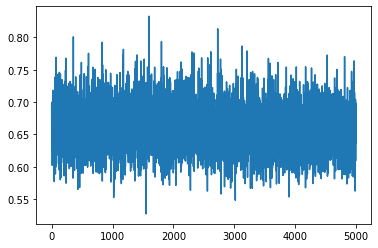

In [244]:
plt.plot((history))


### Evaluate BPRP Sensitivity

Text(0.5, 1.0, 'H-Beta Line')

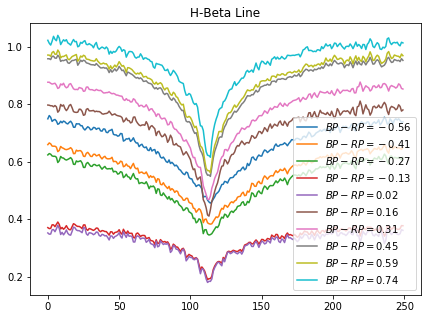

In [245]:
plt.figure(figsize=(7,5))
ts = np.linspace(min(bprps),max(bprps),10)
ls = np.linspace(np.mean(gs),np.mean(gs),10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = msc.inverse_transform(model.predict(samples))
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(gens[i][750:1000],label='$BP-RP = %.2f$'%ts[i])
plt.legend(fontsize=10)
plt.title('H-Beta Line')

### Evaluate G_abs Sensitivity

Text(0.5, 1.0, 'H-Beta Line')

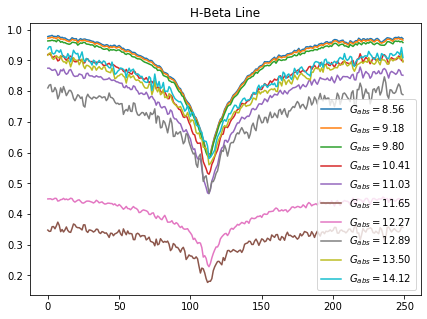

In [246]:
plt.figure(figsize=(7,5))
ts = np.linspace(np.mean(bprps),np.mean(bprps),10)
ls = np.linspace(min(gs),max(gs),10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = msc.inverse_transform(model.predict(samples))
for i in range(len(gens)):
    plt.plot(gens[i][750:1000],label='$G_{abs} = %.2f$'%ls[i])

plt.legend(fontsize=10)
plt.title('H-Beta Line')

### Evaluate Residuals of Random Control Spectra

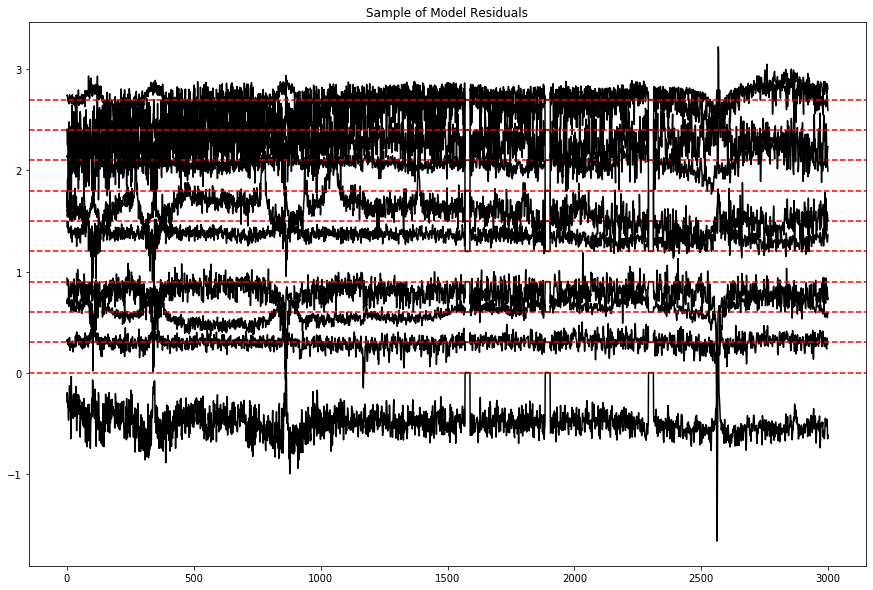

In [248]:
resids = model.predict(X)-t 
plt.figure(figsize=(15,10))
ct=0
for i in np.random.randint(0,len(resids),10):
    plt.plot(resids[i] + 0.3*ct,'k')
    plt.axhline(0.3*ct,color='r',linestyle='--')
    ct += 1
    plt.title('Sample of Model Residuals')

# Autocorr Method

In [269]:
resids = model.predict(X) - t

In [324]:
autos = [];
corrtimes = [];
for i in range(len(resids)):
    autocorr = np.correlate(resids[i],resids[i],mode='full')
    autocorr = autocorr/max(autocorr)
    corrtime = 3000-np.argmax(autocorr > 1/np.exp(1))
    autos.append(autocorr)
    corrtimes.append(corrtime)

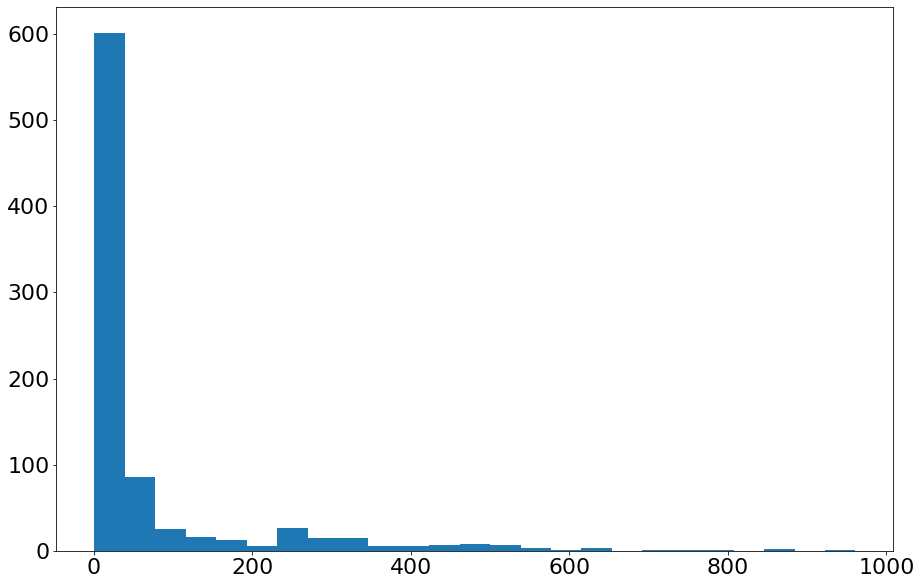

In [325]:
plt.hist(corrtimes,bins=25);

In [306]:
outliers = np.asarray(corrtimes) > 600
outspec = normspec[outliers]
outpred = model.predict(X)[outliers]

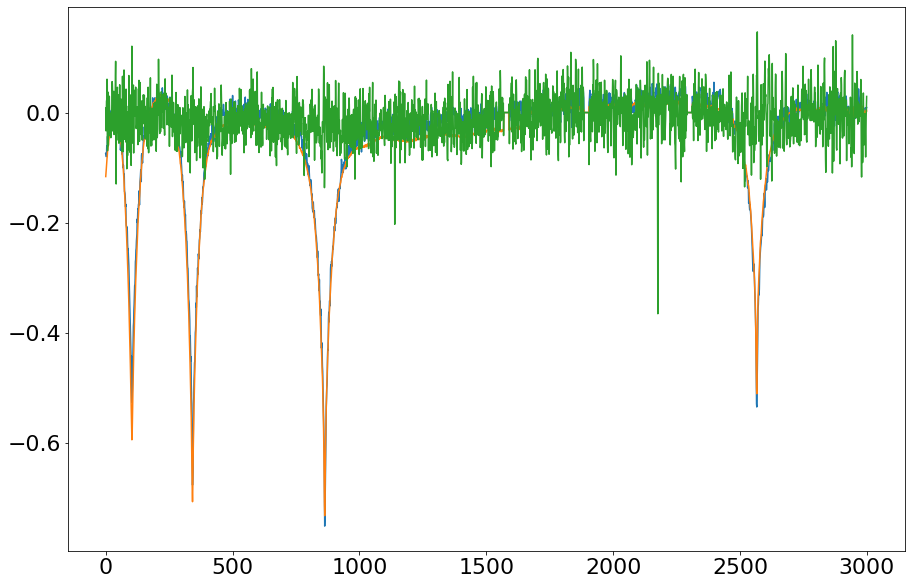

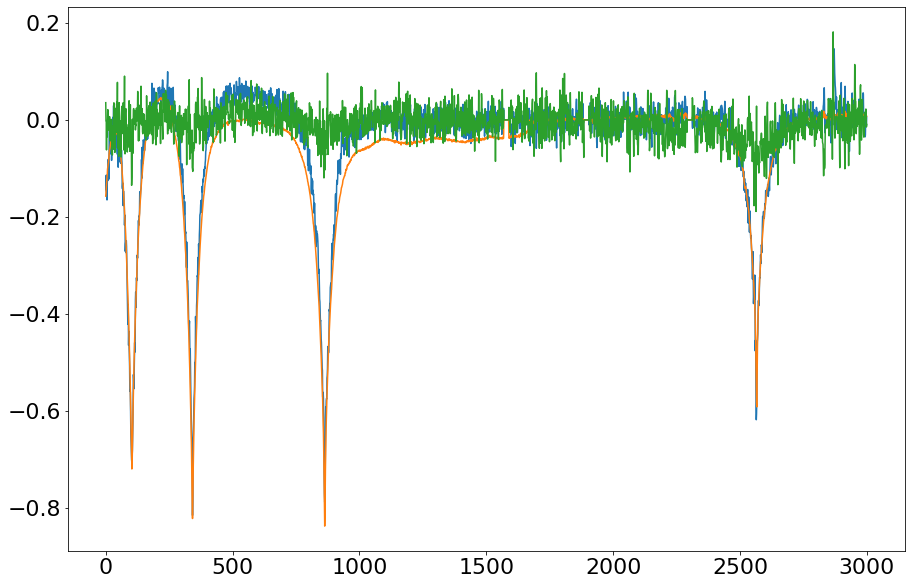

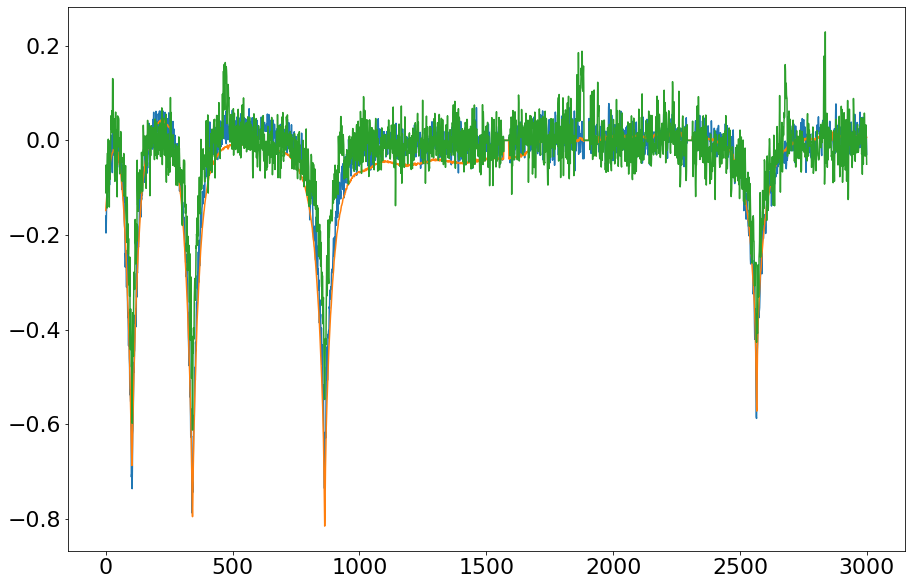

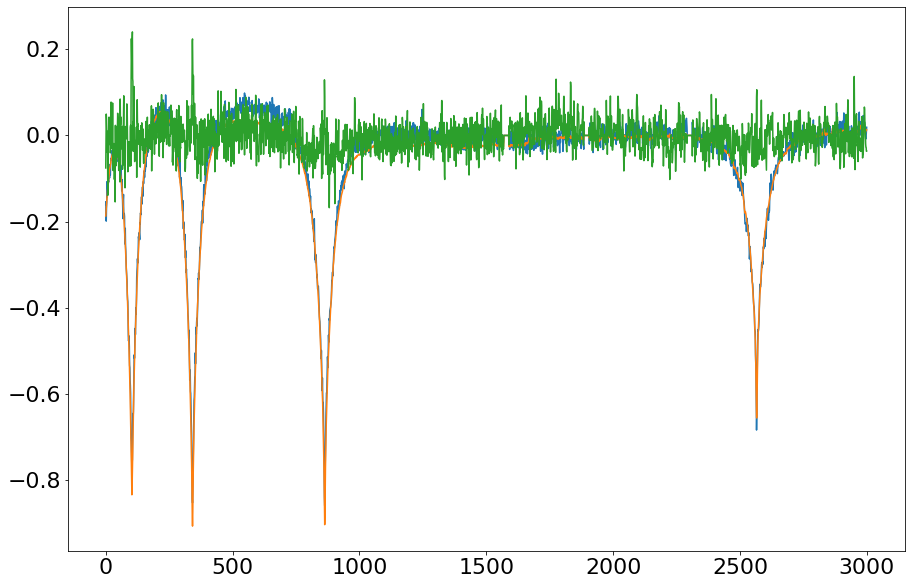

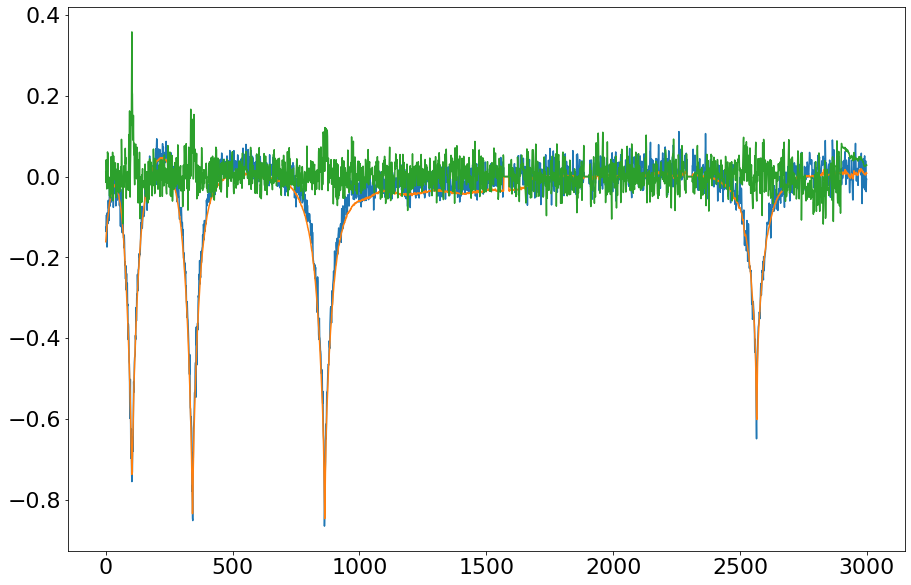

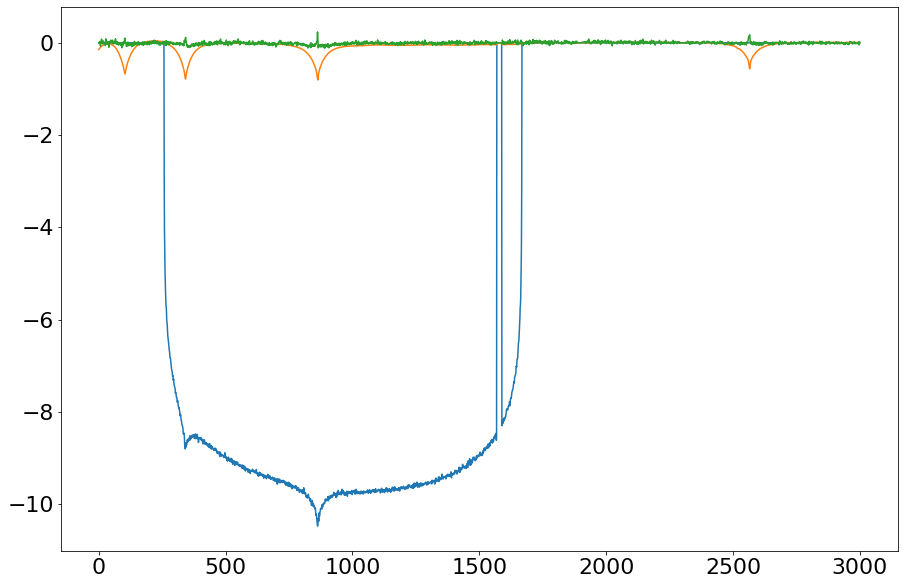

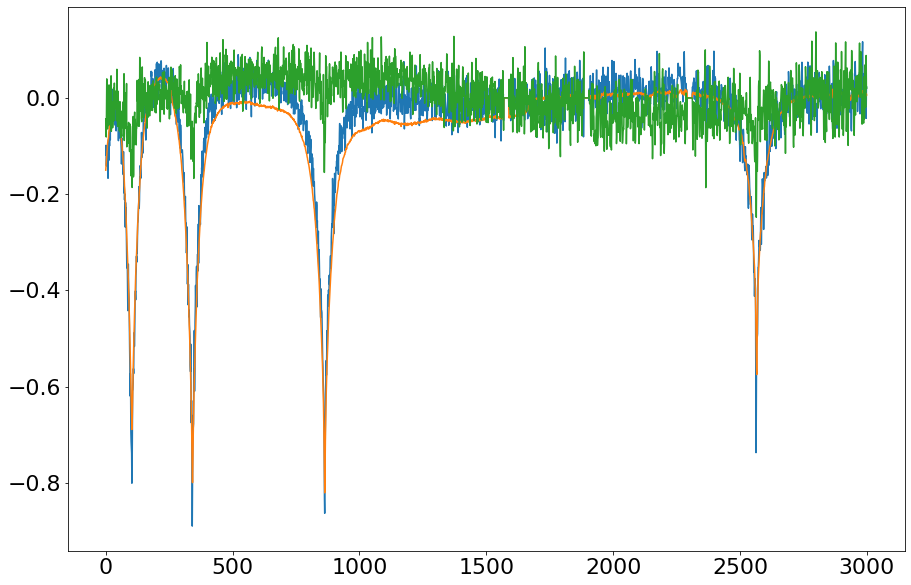

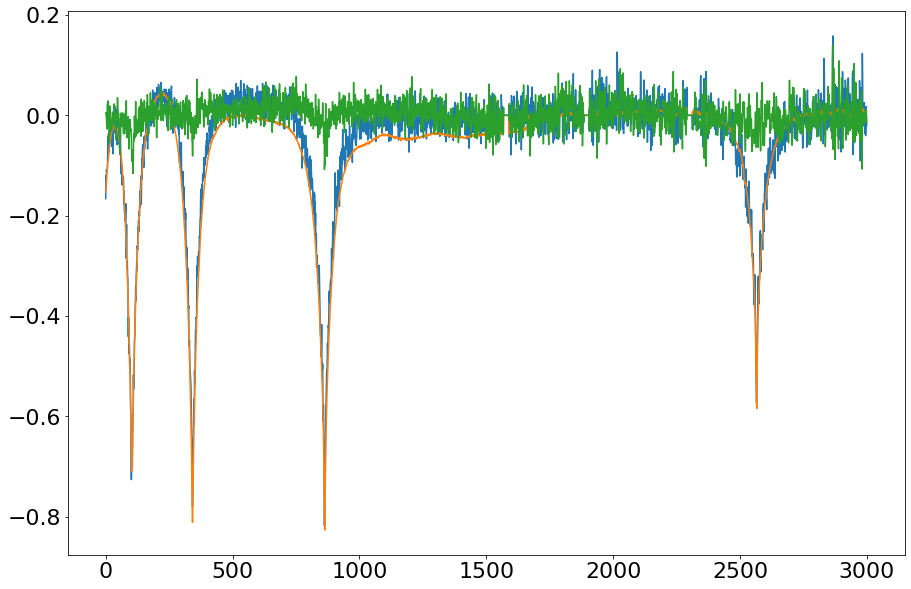

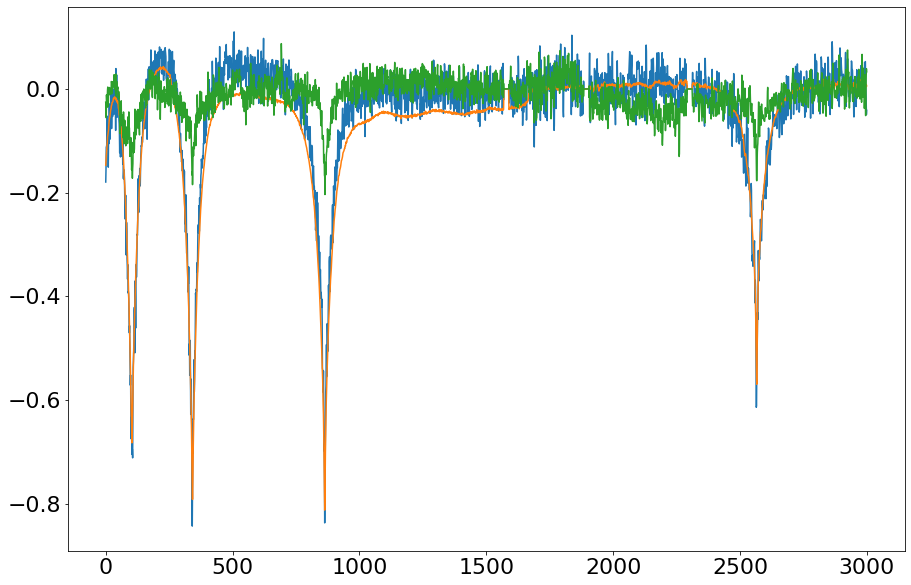

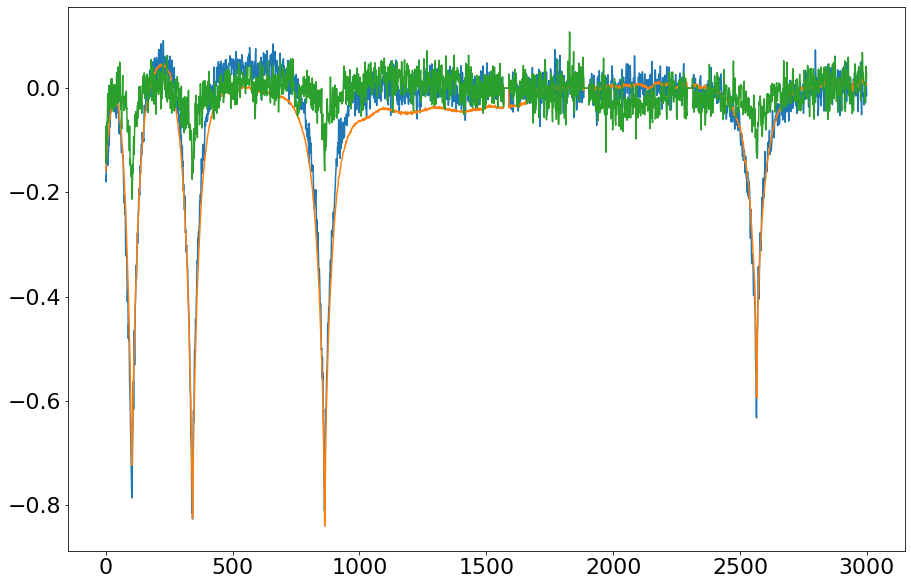

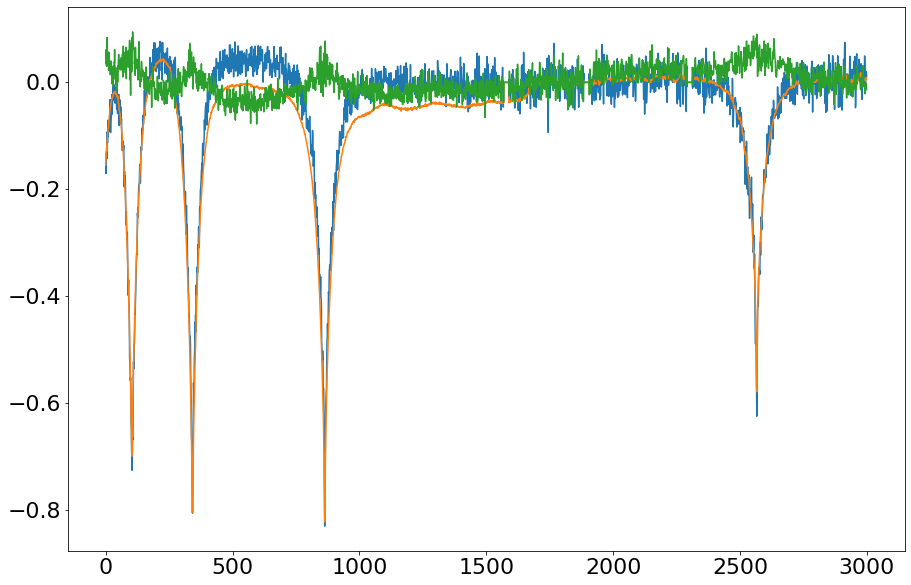

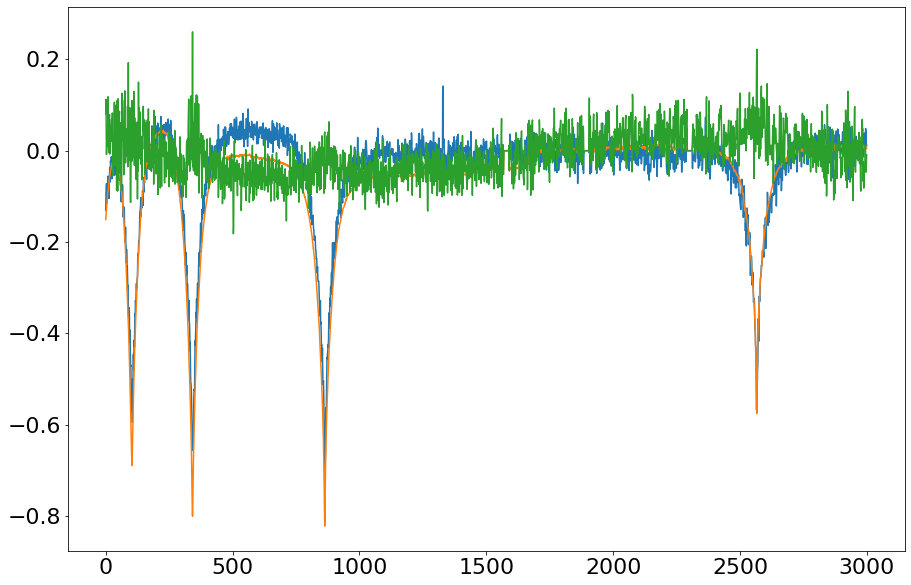

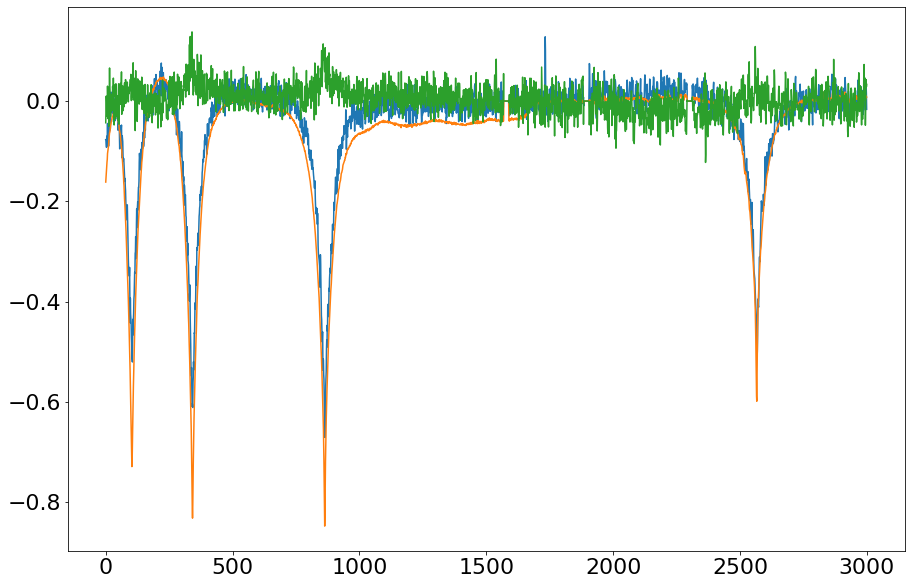

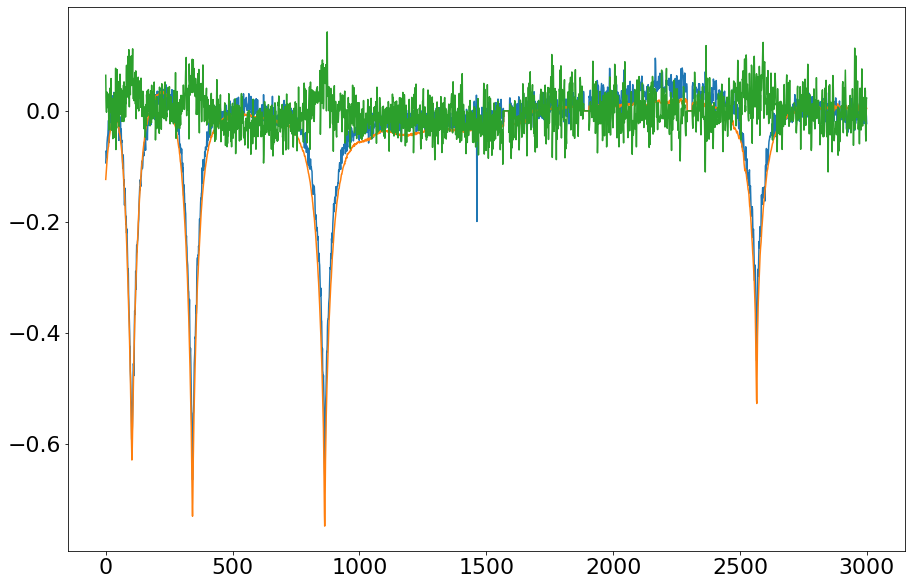

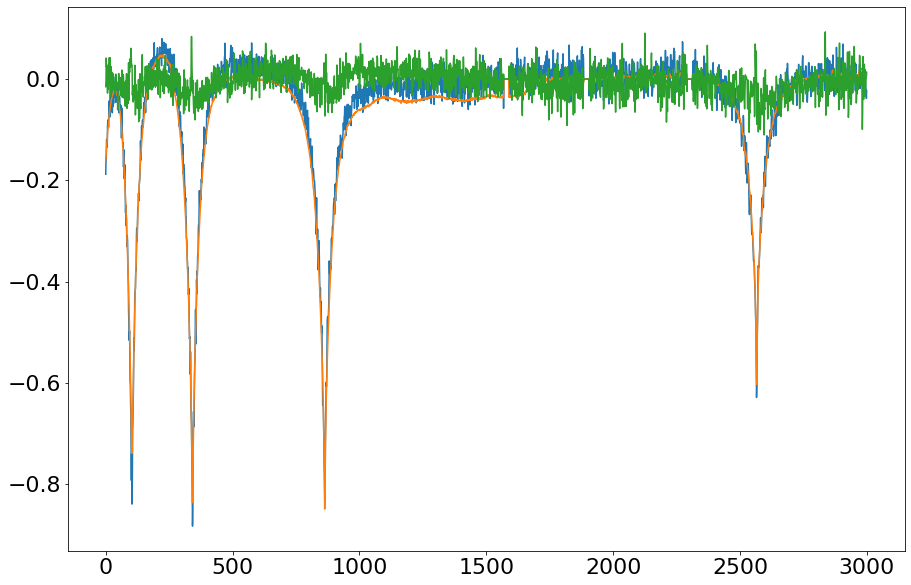

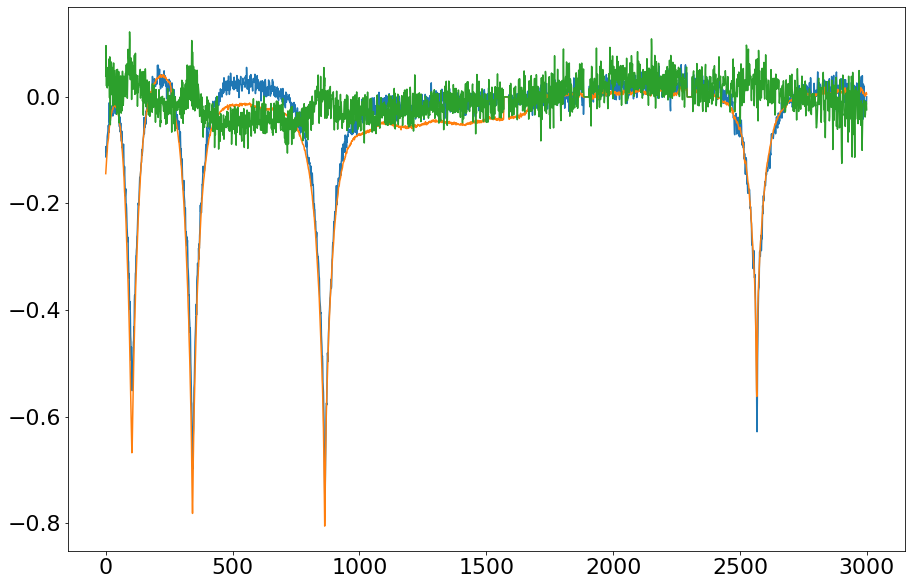

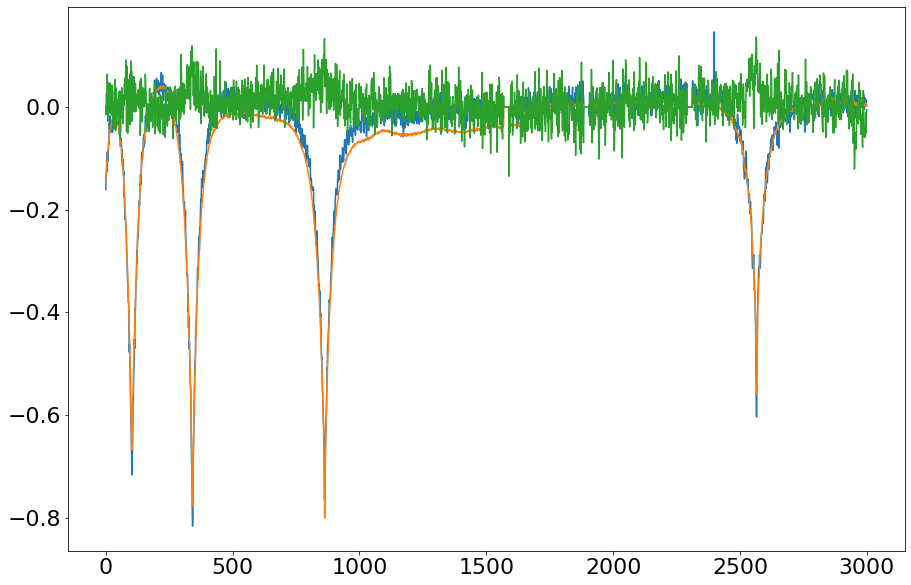

In [309]:
for i in range(sum(outliers)):
    plt.plot(outspec[i])
    plt.plot(outpred[i])
    plt.plot(resids[i])
    plt.show()

# Shapiro Test

In [262]:
shaps = [];
for i in range(len(resids)):
    shaps.append(stats.shapiro(resids[i])[0])

In [263]:
shaps = np.asarray(shaps)

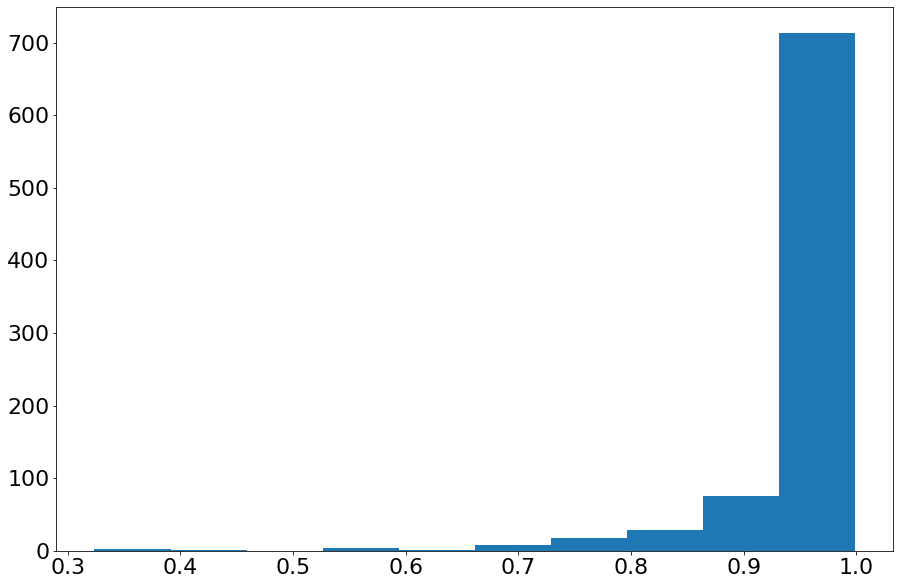

In [264]:
plt.hist(shaps);

In [265]:
outliers = shaps < 0.75

outspec = normspec[outliers]
outpred = model.predict(X)[outliers]

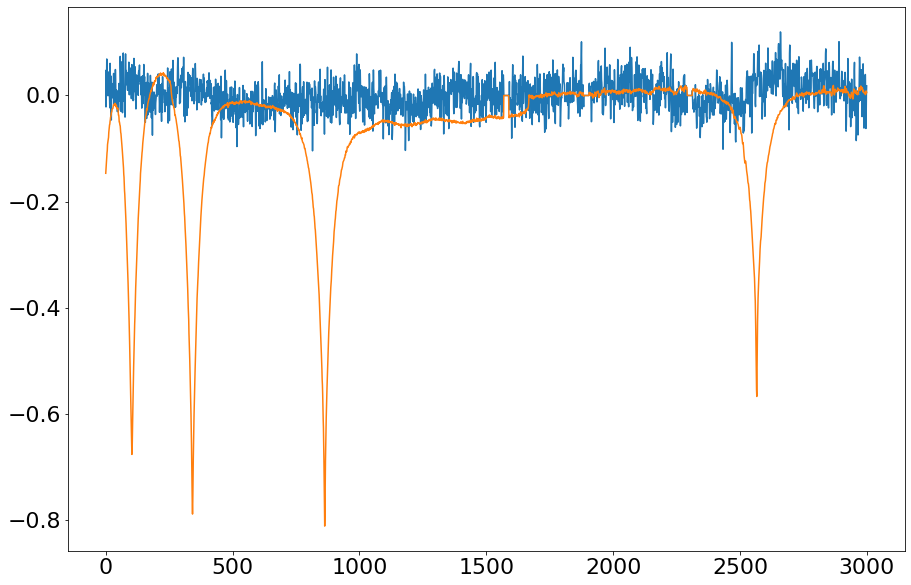

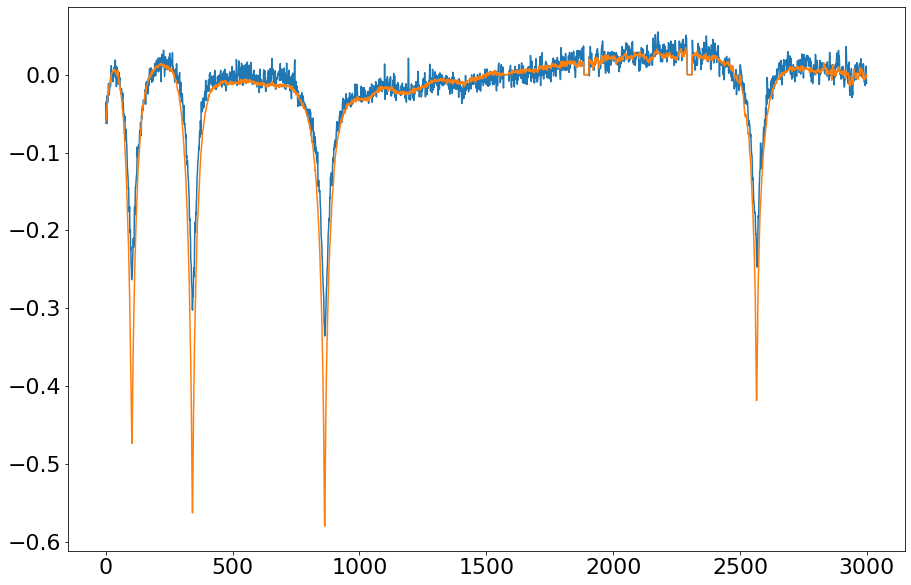

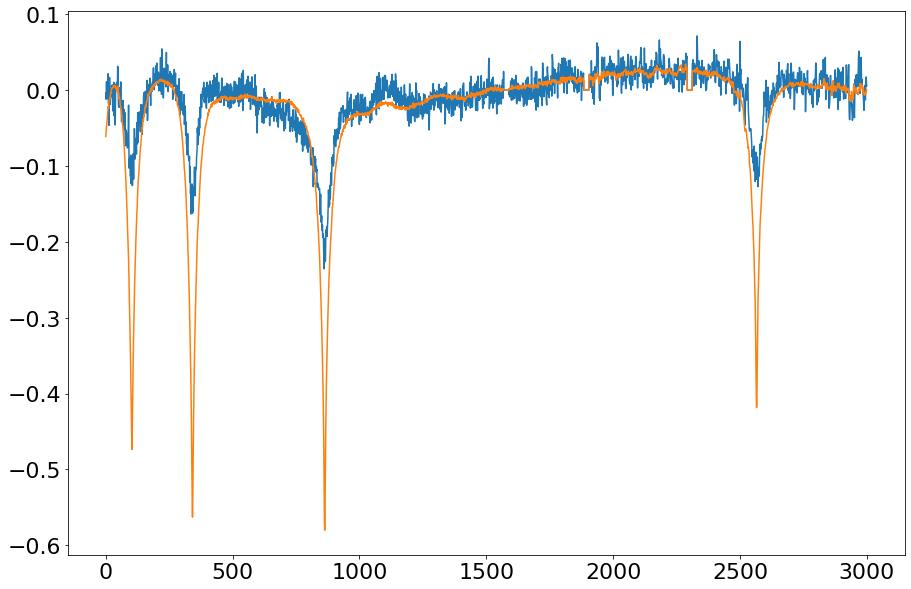

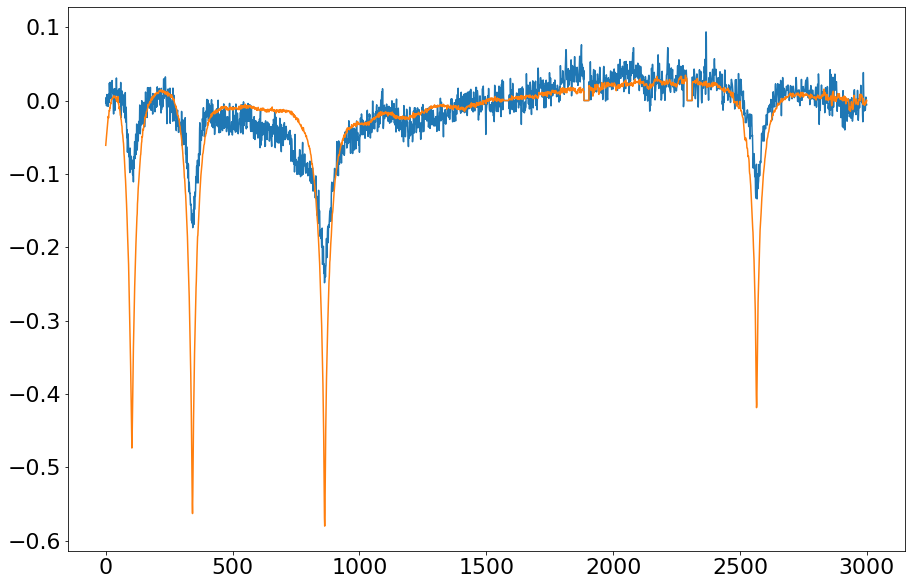

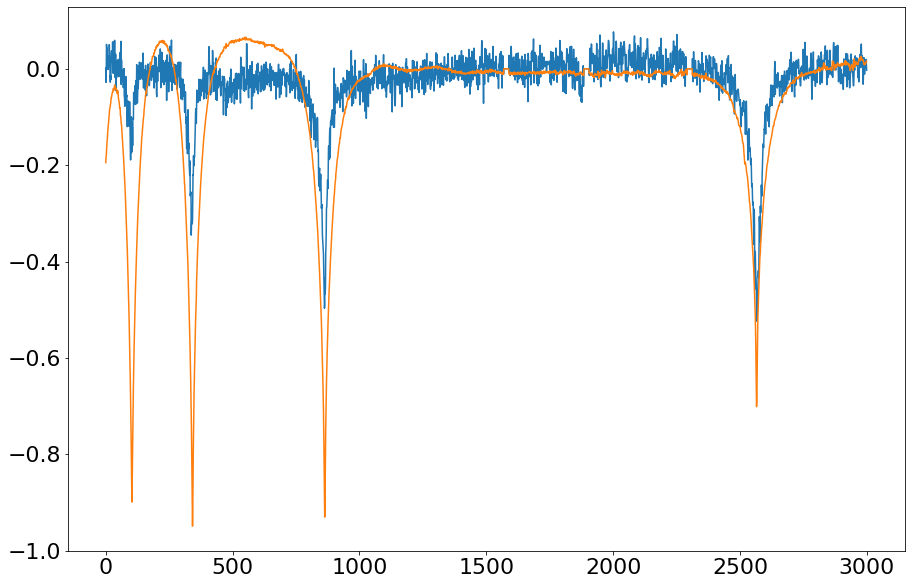

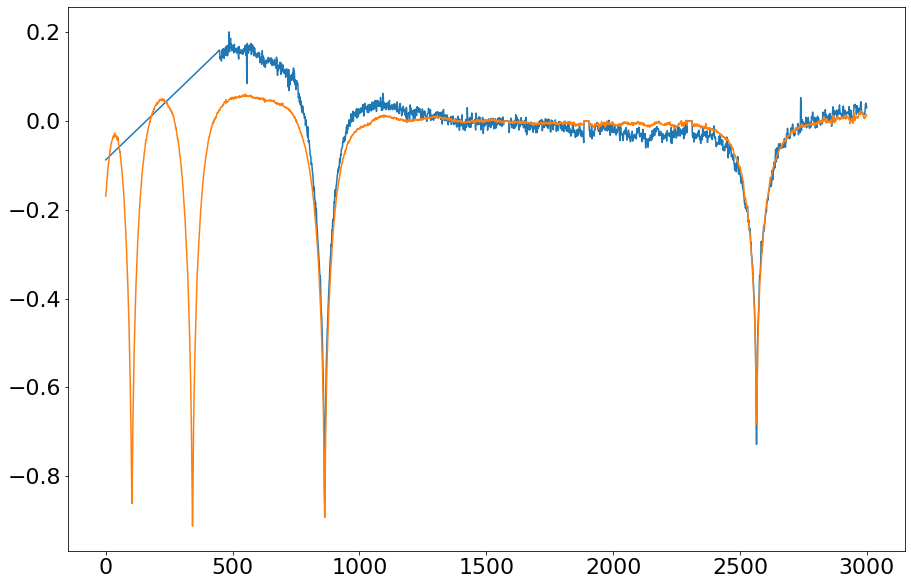

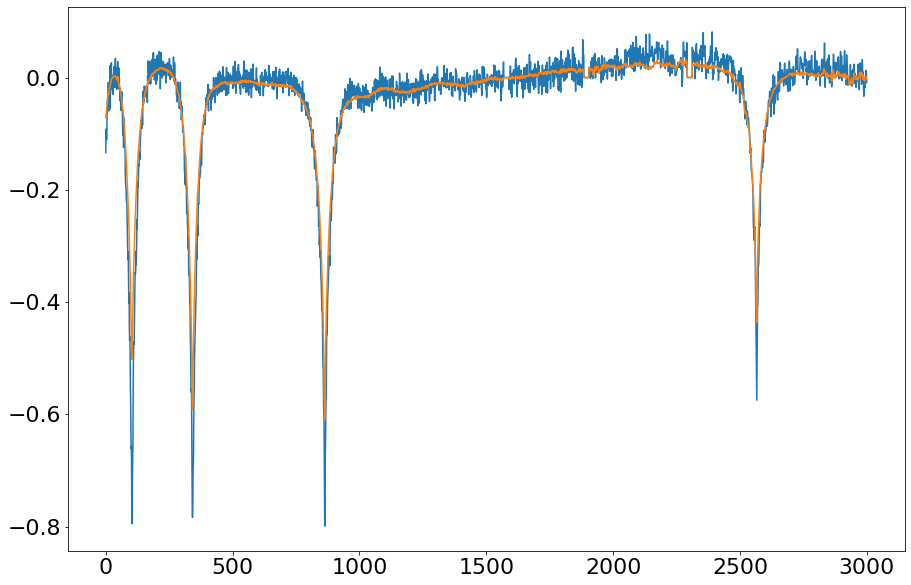

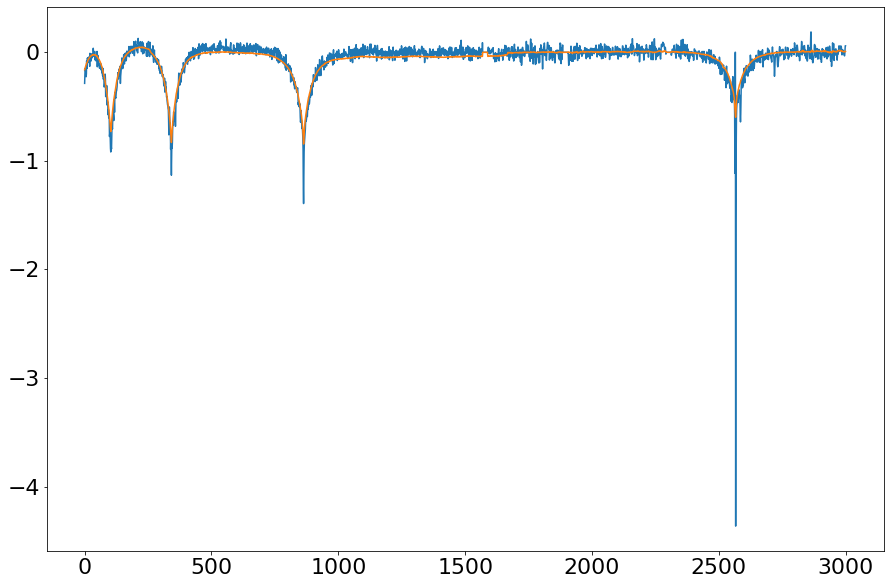

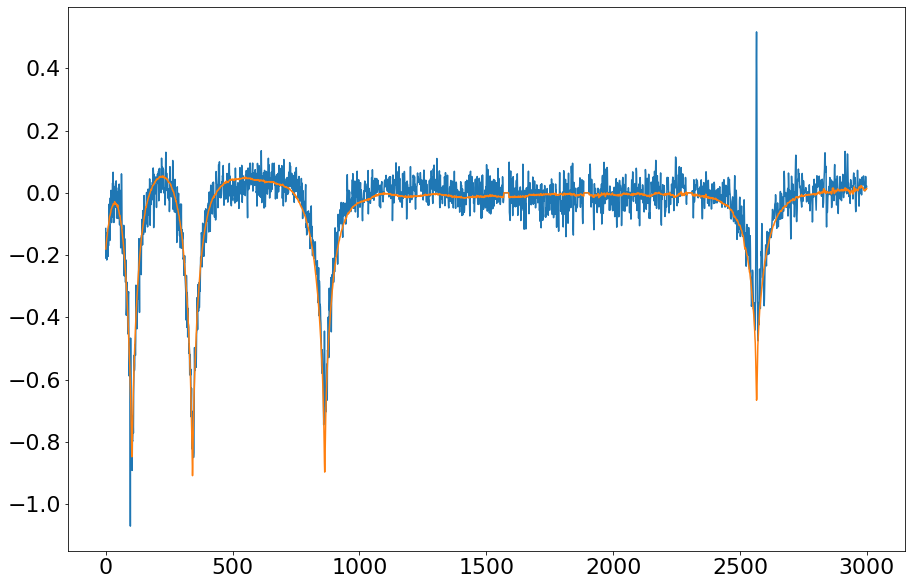

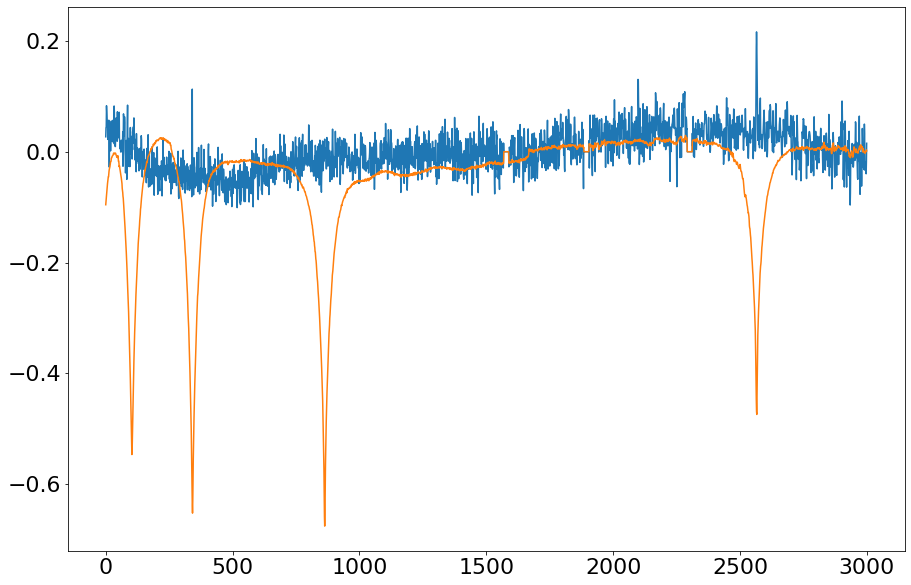

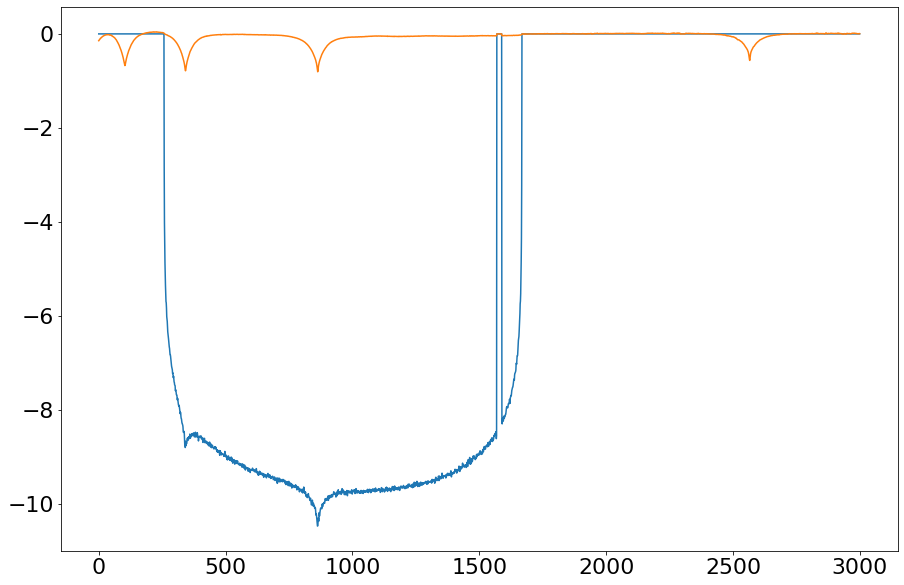

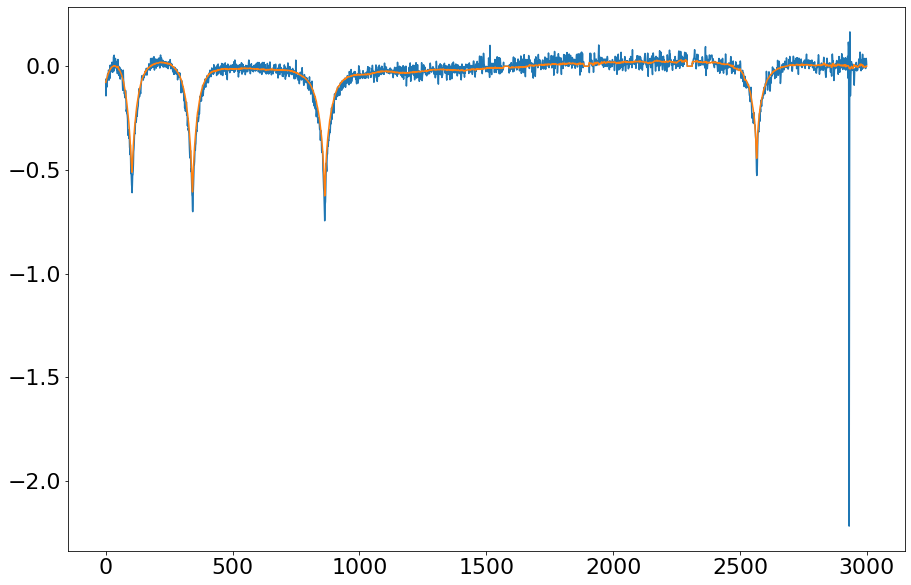

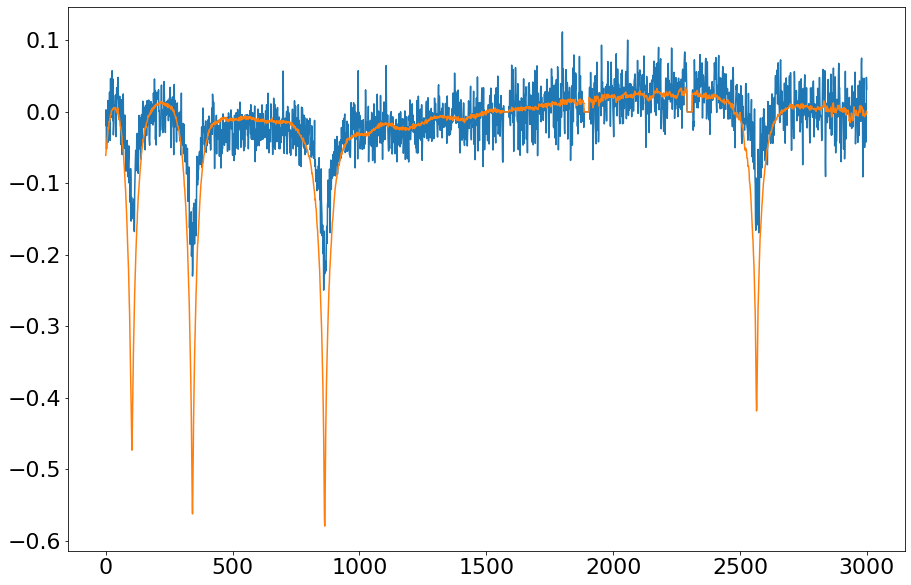

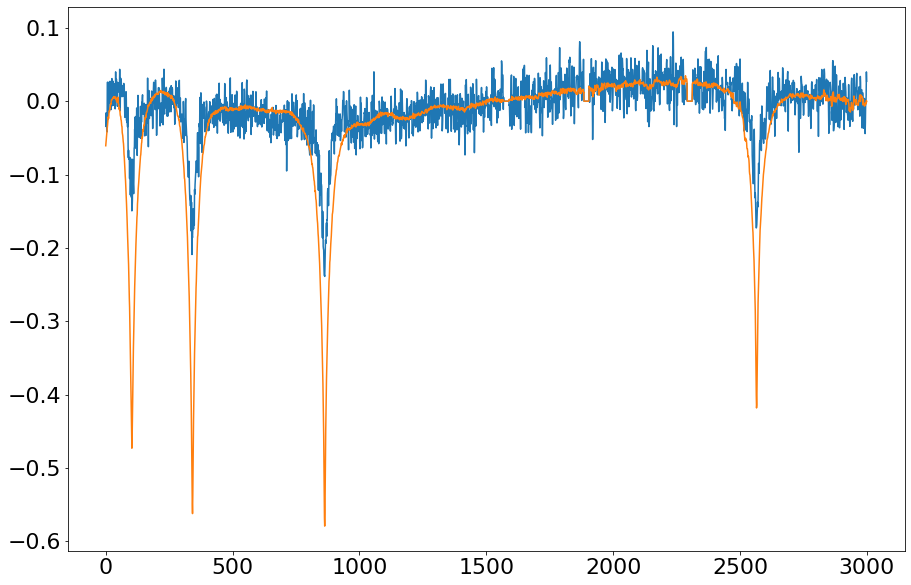

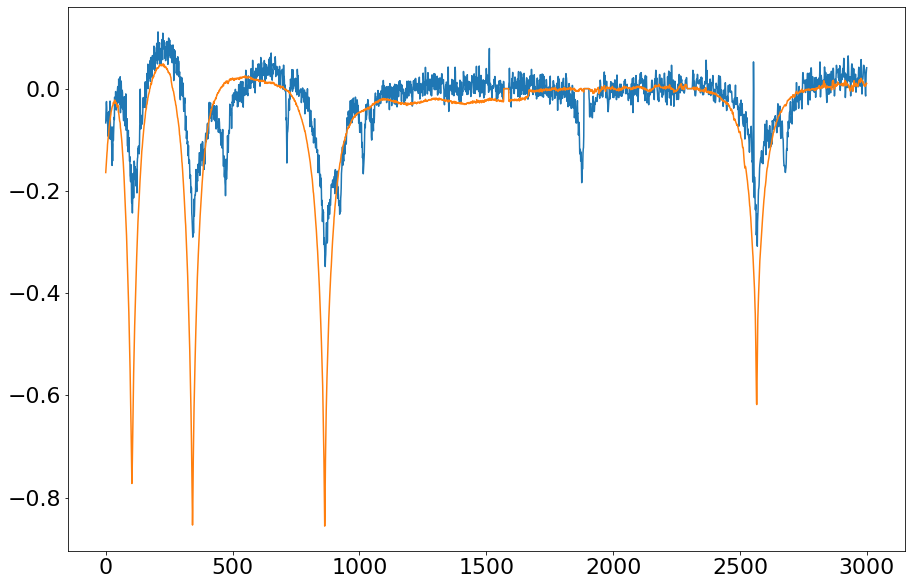

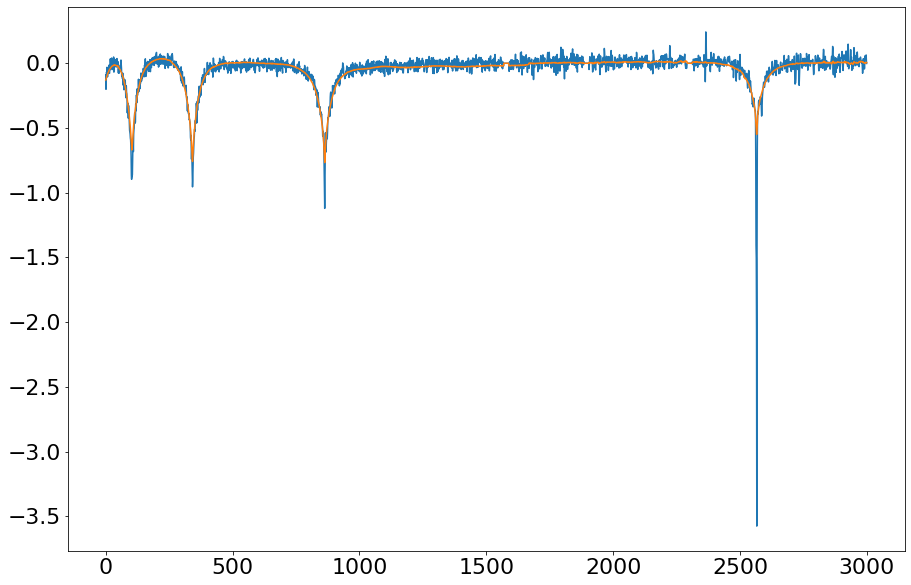

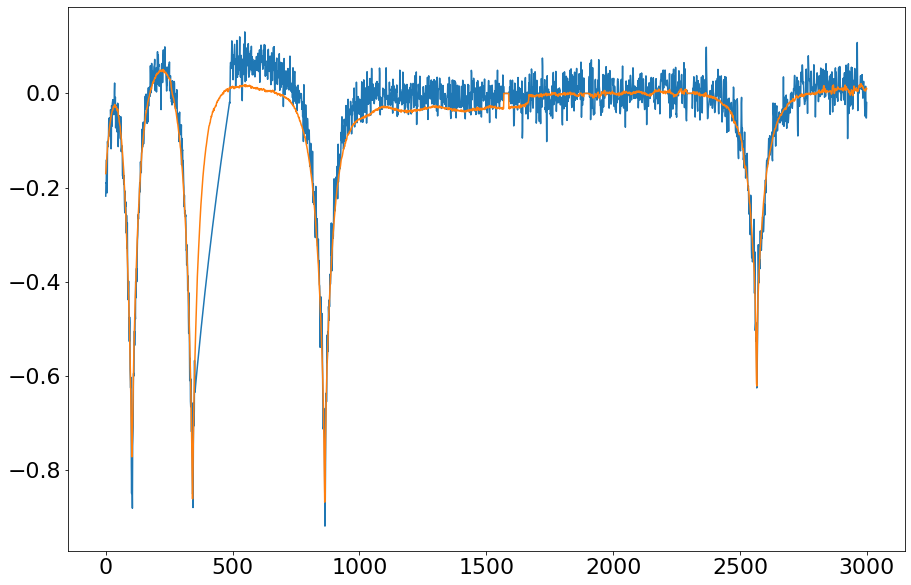

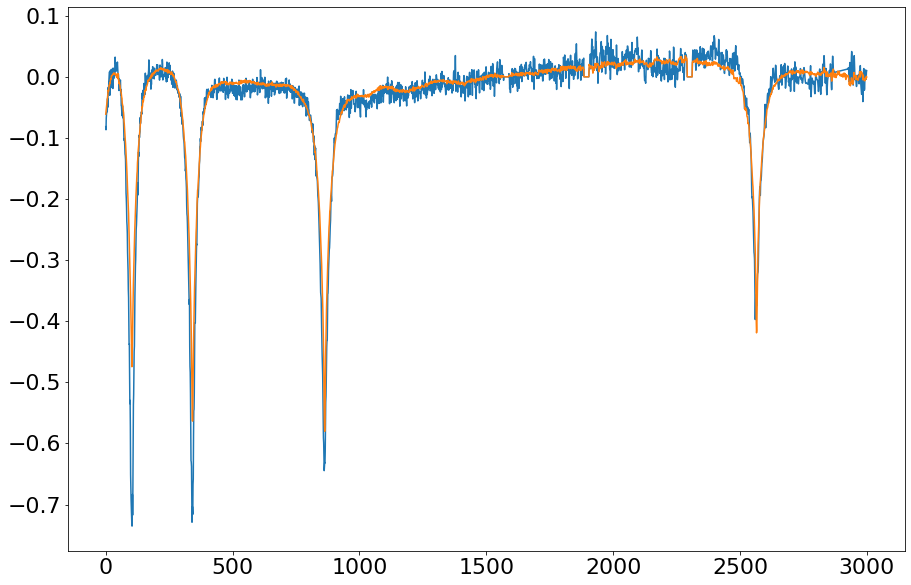

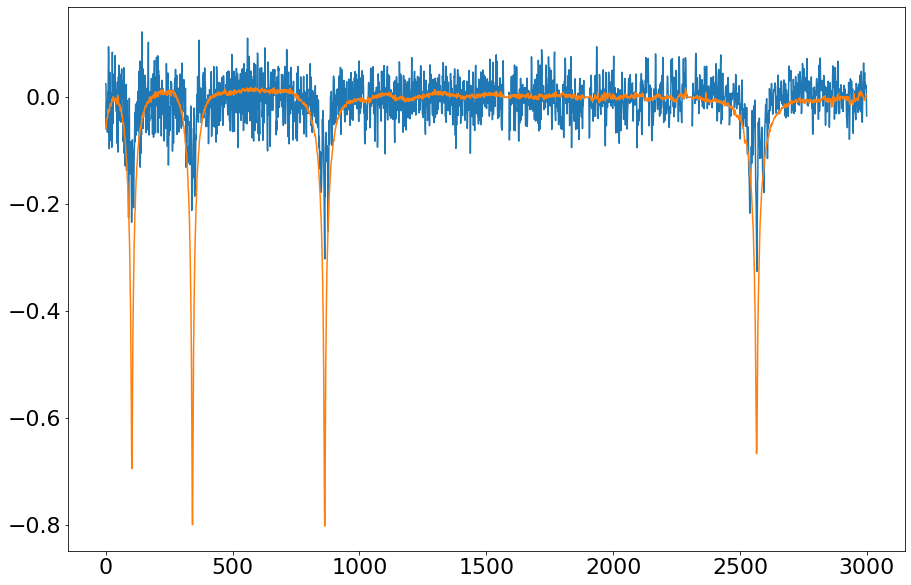

In [266]:
for i in range(sum(outliers)):
    plt.plot(outspec[i])
    plt.plot(outpred[i])
    plt.show()

# Skewness Test

In [228]:
shuffs = copy.deepcopy(resids)

In [234]:
random.shuffle(shuffs)

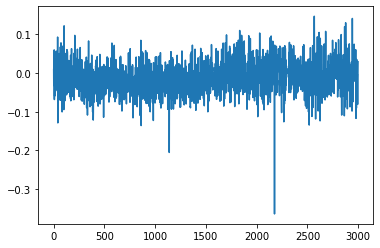

In [237]:
plt.plot(shuffs[12])

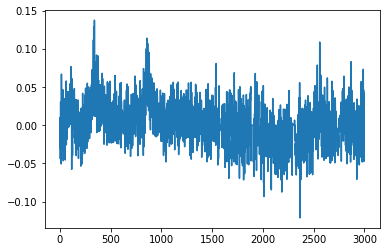

In [236]:
plt.plot(resids[12])

In [241]:
corrs = [];
for i in range(len(resids)):
    corrs.append(np.corrcoef(shuffs[i],resids[i])[0,1])

In [243]:
outliers = np.abs(corrs) > 0.5

In [248]:
outspec = normspec[outliers]
outpred = model.predict(X)[outliers]
outnames = np.asarray(specnames)[outliers]

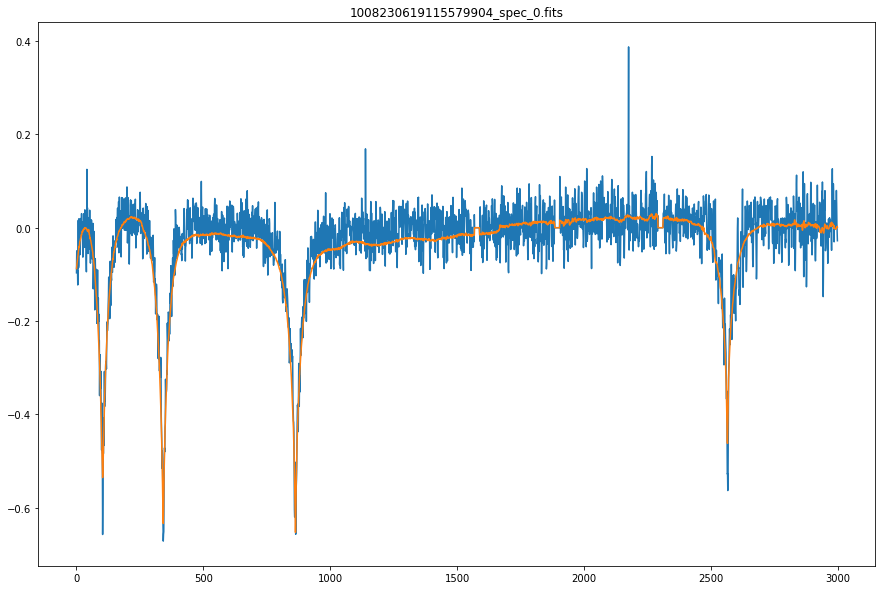

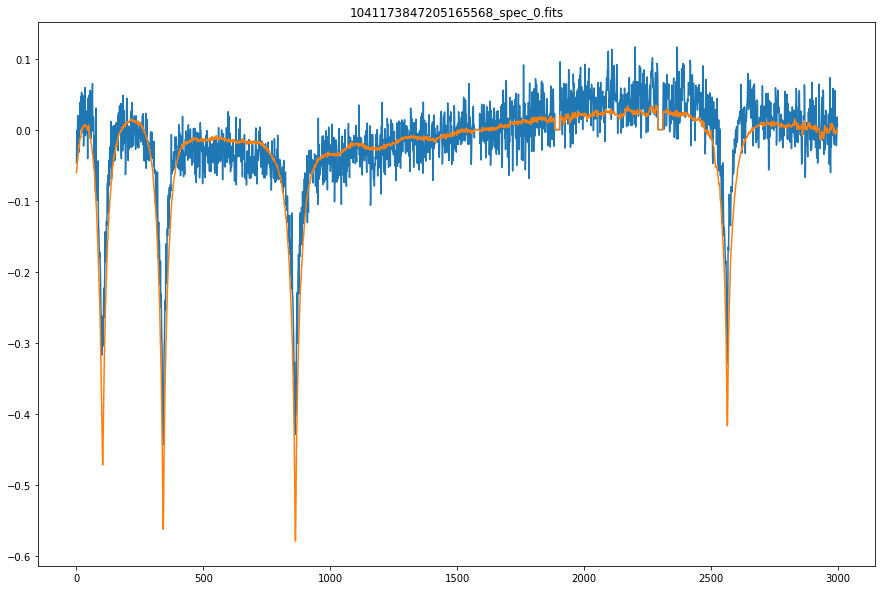

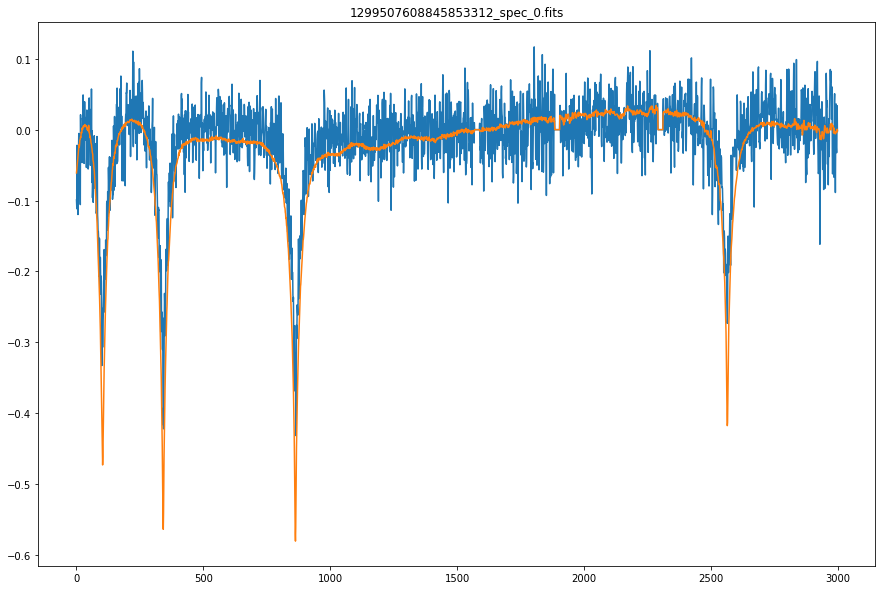

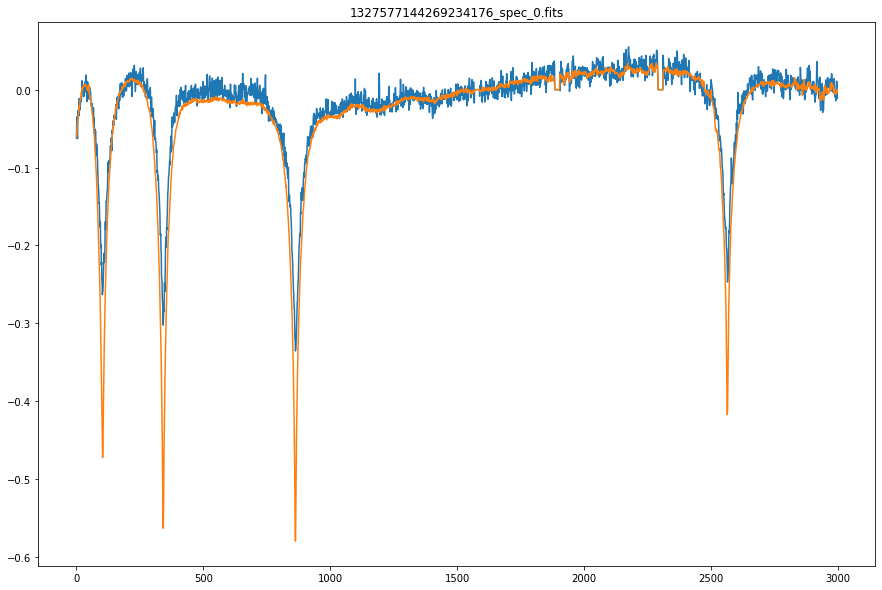

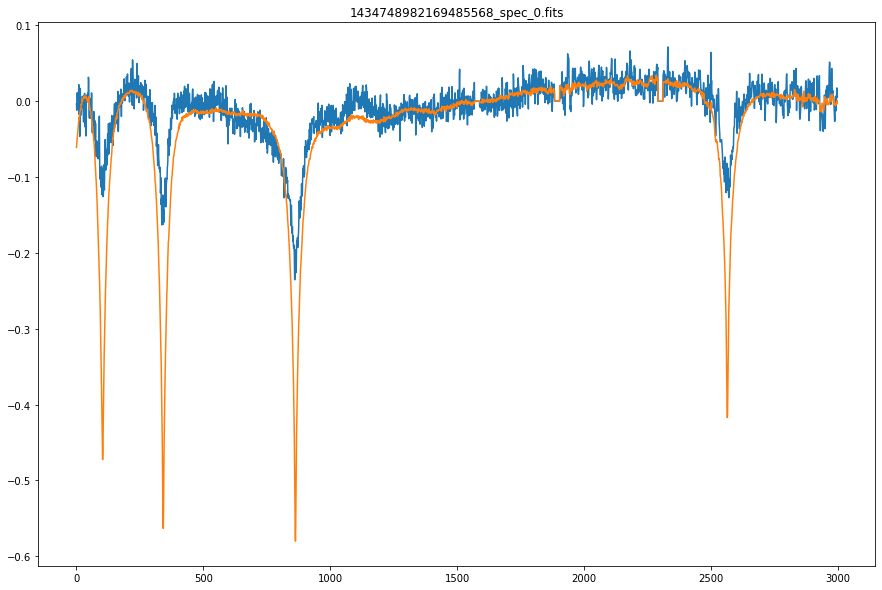

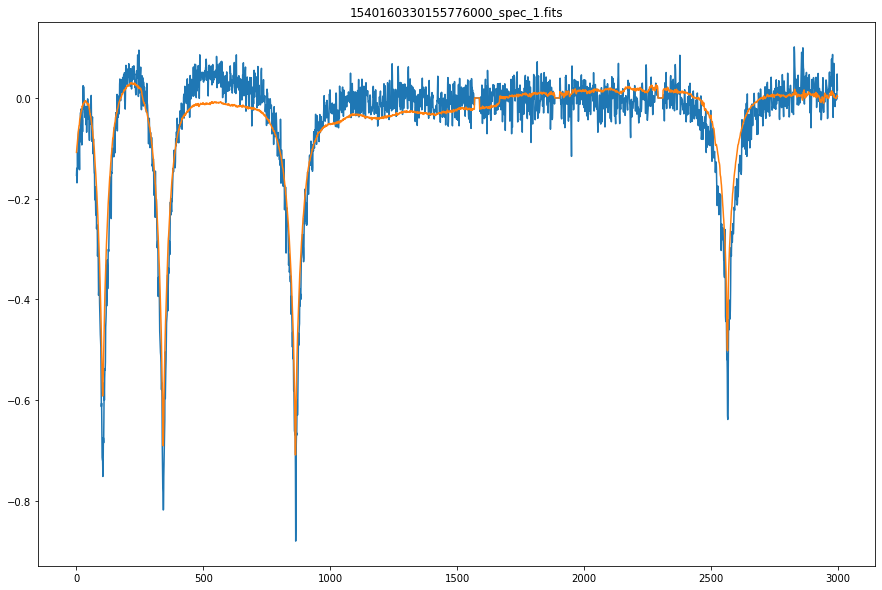

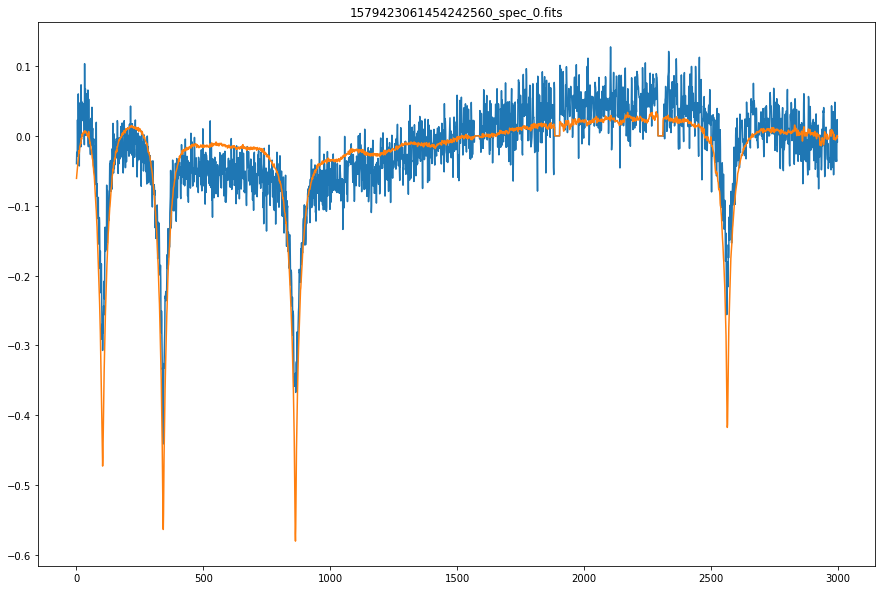

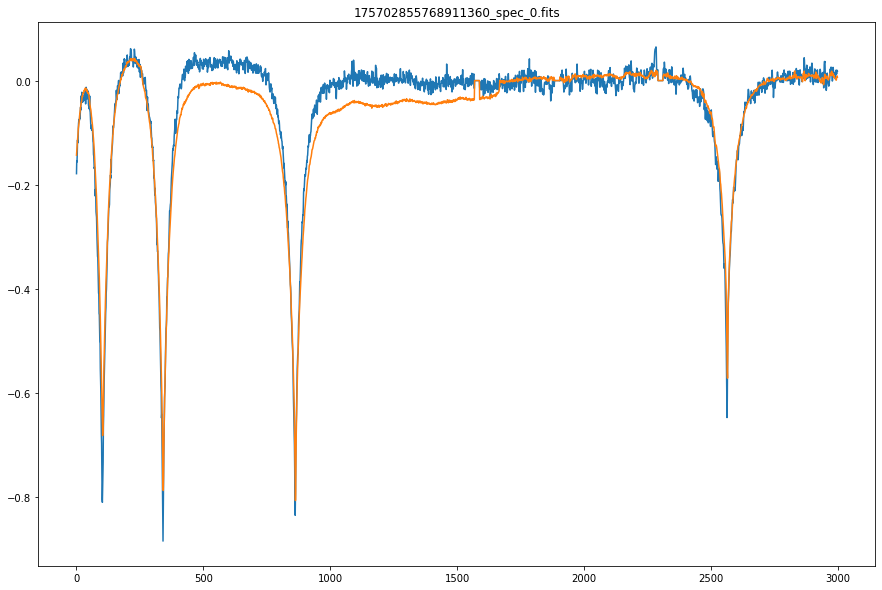

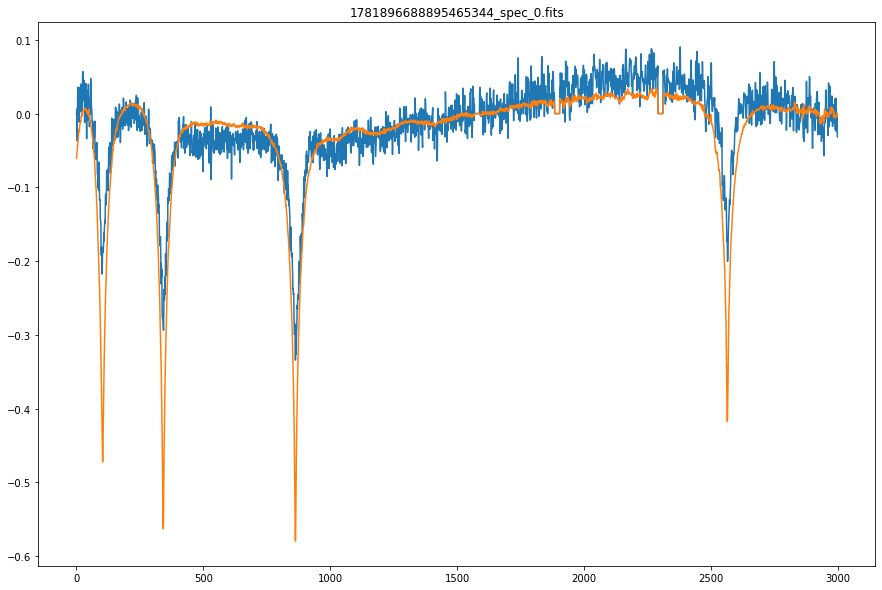

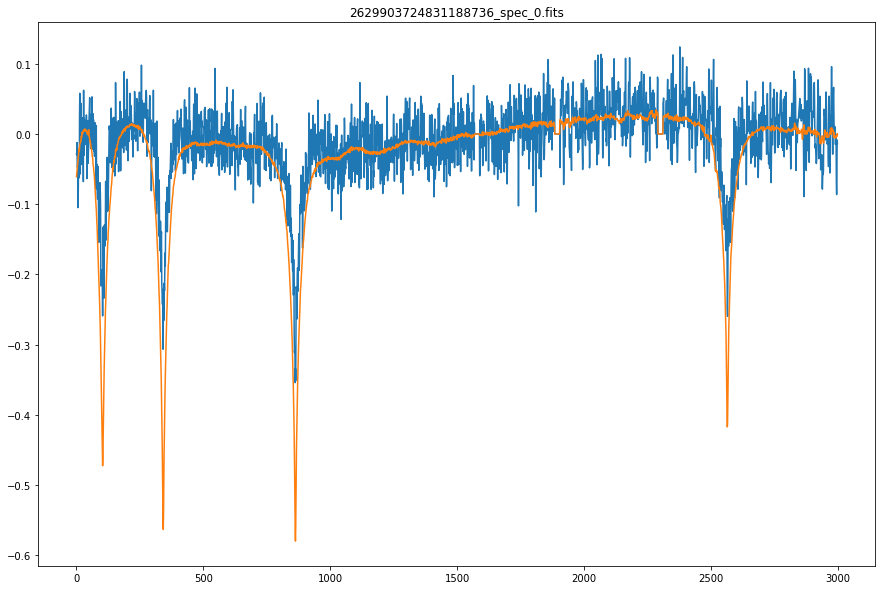

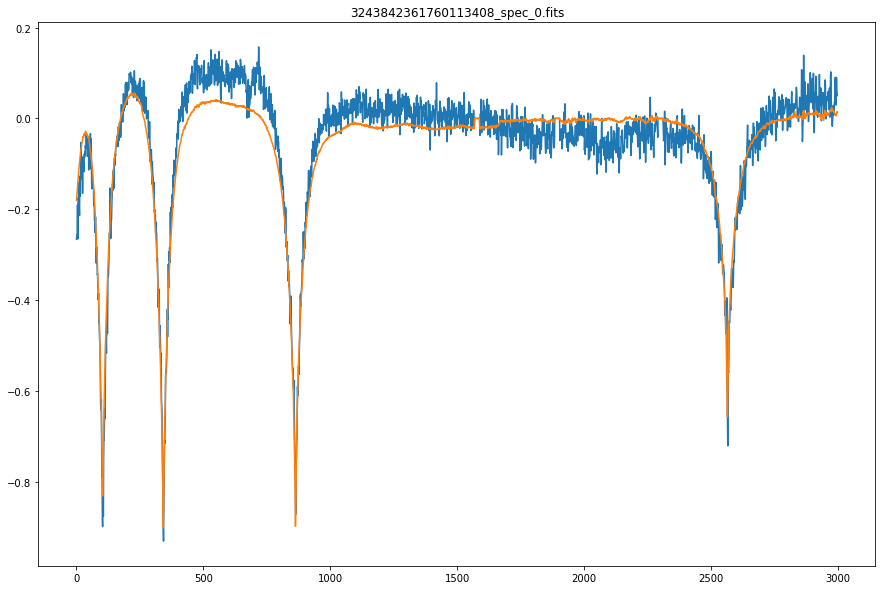

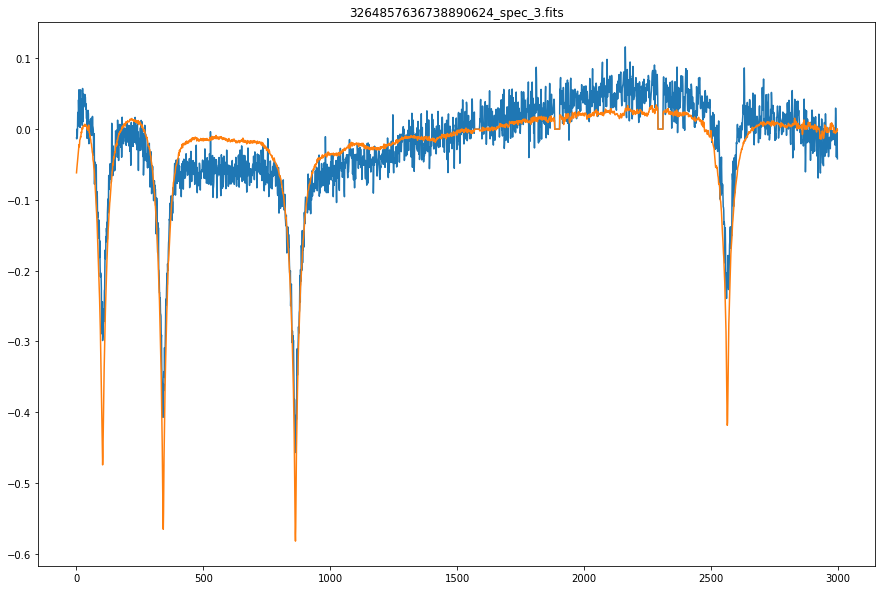

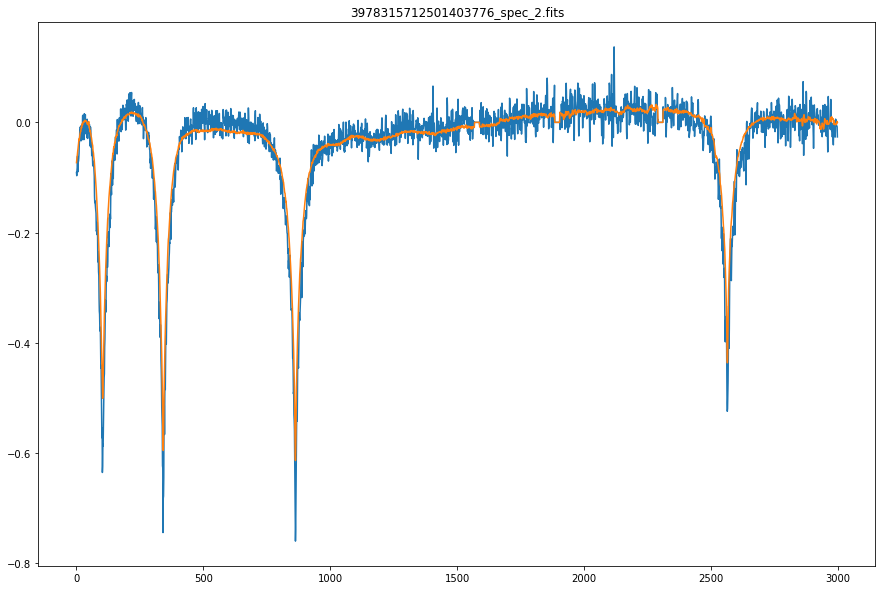

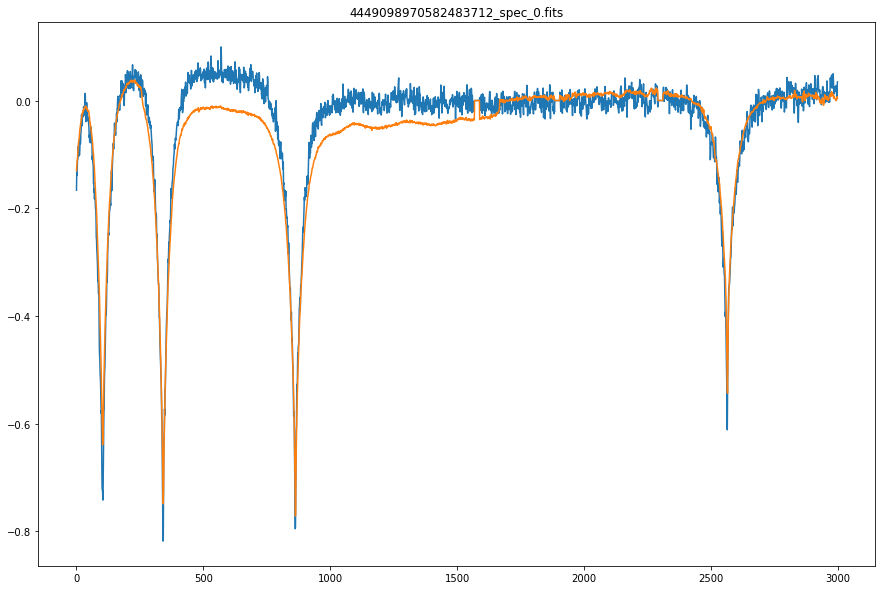

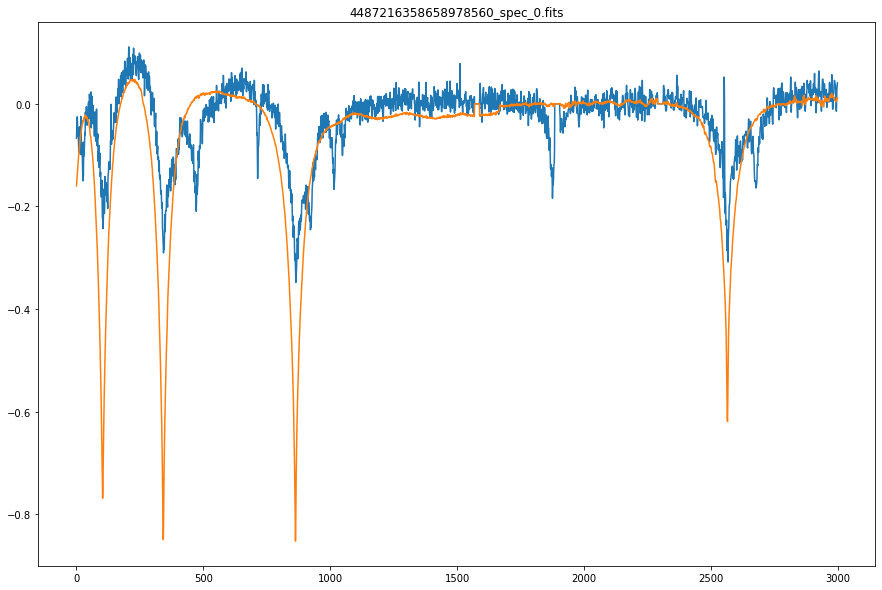

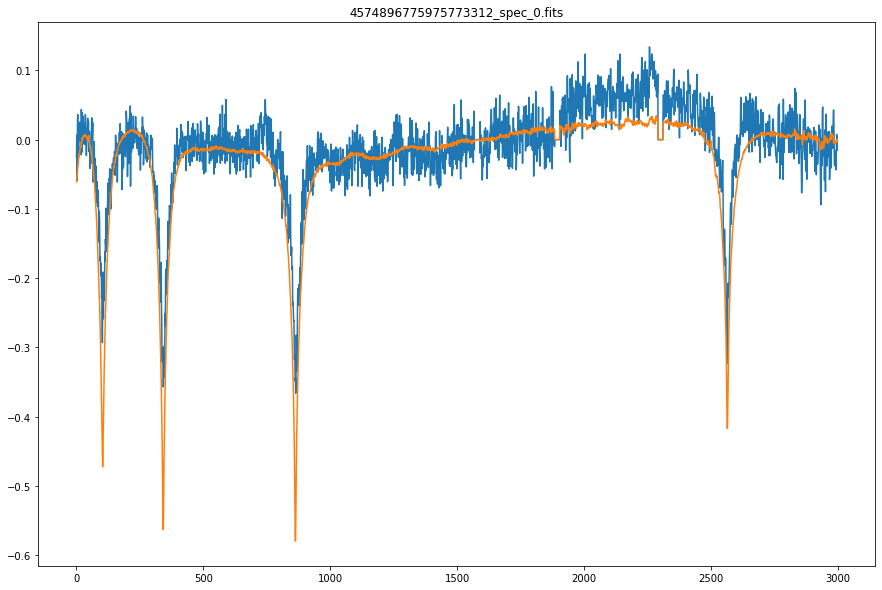

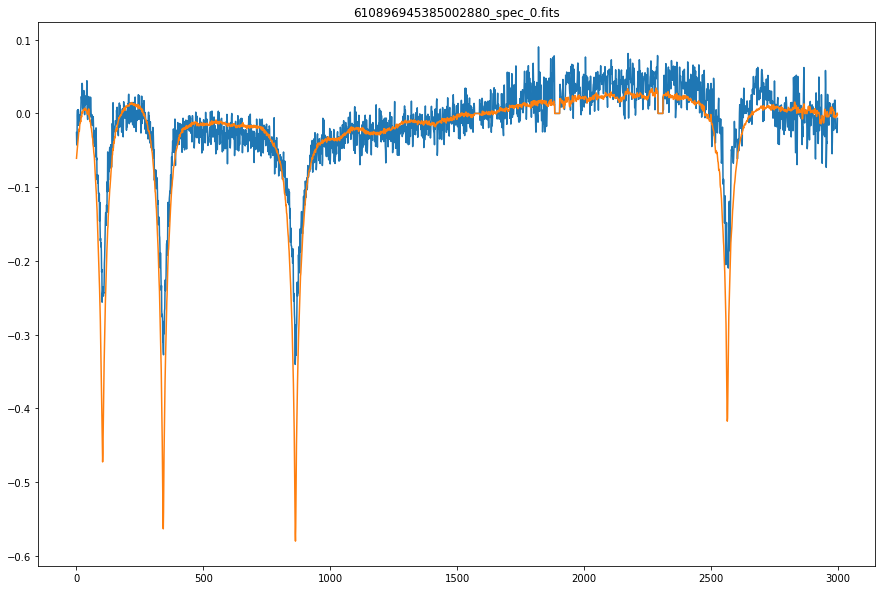

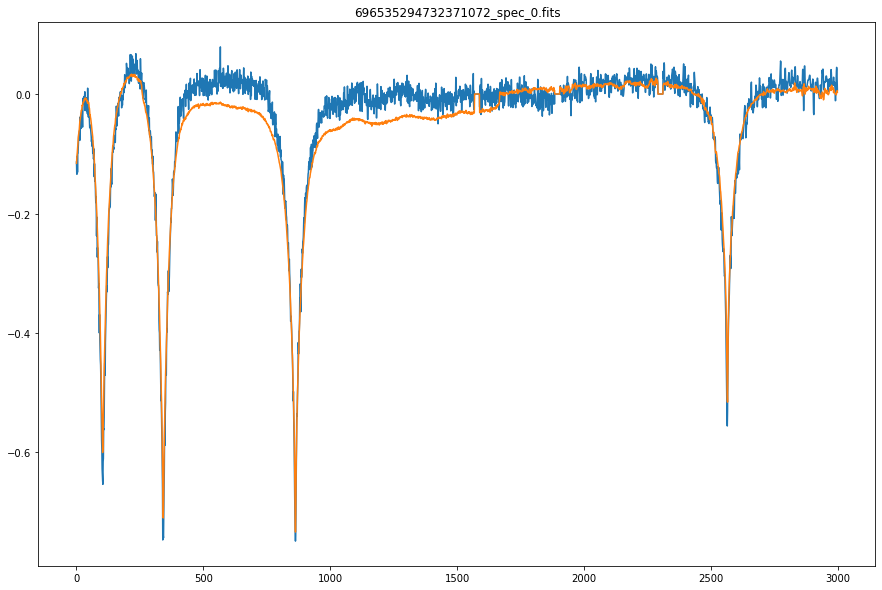

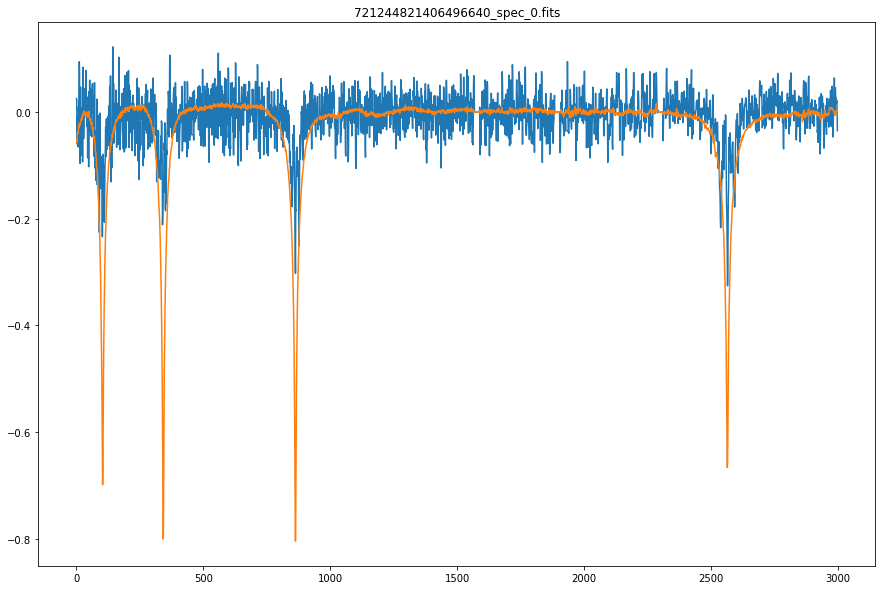

In [249]:
for i in range(sum(outliers)):
    plt.figure(figsize=(15,10))
    plt.plot(outspec[i])
    plt.plot(outpred[i])
    plt.title(outnames[i])
    plt.show()

In [254]:
wdtable[wdtable['specnames'] == '4487216358658978560_spec_0']

<Table masked=True length=1>
        specnames               sigma_a       ...        S2N       
                                              ...                  
         bytes27                float64       ...      float64     
-------------------------- ------------------ ... -----------------
4487216358658978560_spec_0 47.279160918656935 ... 3.675846255797557

In [251]:
outnames[14]

'4487216358658978560_spec_0.fits'